# Import Libraries

In [33]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from ipywidgets import HBox, VBox,Layout
import numpy as np
import random
import uuid
import random
import datetime
import geopandas as gpd
import folium
from folium.features import GeoJson, GeoJsonTooltip
import matplotlib.pyplot as plt; plt.rcdefaults()
import copy
import branca.colormap as cm
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from folium.features import GeoJson, GeoJsonTooltip
pd.options.display.max_columns=50

In [34]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Classes


## Random 🎲🎲

In [35]:
class ridt_random:
    
    def random_dates_list(start, end, n):
        """ recieves a START date
        and an END date
        and a N number of random Dates"""
        start_u = start.value//10**9
        end_u = end.value//10**9
        return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n, dtype=np.int64)).view('M8[ns]')) 

## RIDT Info ℹ️

In [99]:
class ridt_info:
    last_year_of_simulation = 2050 # Define the last year of the simulaiton
    end_of_simulation_date =  pd.to_datetime((datetime.date(last_year_of_simulation, 1, 1)))
    ami_100_percent=91000
    affordable_category = {
    'Rental':'Rental',
    'Rental & Coop':'Rental',
    'Coop':'Coop',
    'Rntal Condo':'Rental',
    'Condo':'Condo'
    }
    Non_affordable_category = {
        'Rental':'Rental',
        'Rental & Coop':'Coop',
        'Coop':'Coop',
        'Rntal Condo':'Condo',
        'Condo':'Condo'
    }
    #Non Affordable Before Simulation
    non_affordable ={
        ### Change according to Year!!!
        'min': 35000,
        'max': 100000
    }
    affordable_models = {
        'Southtown':{
            'type':'multi',
            'a' :{
                'ap_percent': 0.15,
                'ami_percent_min':0.5,
                'ami_percent_max':0.8            
            },
            'b':{
                'ap_percent': 0.35,
                'ami_percent_min':1.2,
                'ami_percent_max':1.48            
            }
        },
        'Other' : {
            'type':'default',
            'Upper':{
                'ami_percent_min':1.2,
                'ami_percent_max':1.48                
            },
            'Middle':{
                'ami_percent_min':0.8,
                'ami_percent_max':1.2                 
            },
            'LowMed':{
                'ami_percent_min':0.1,
                'ami_percent_max':0.3                  
            }
        },
        'Northtown' : {
            'type':'default',
            'Upper':{
                'ami_percent_min':1.2,
                'ami_percent_max':1.48                
            },
            'Middle':{
                'ami_percent_min':0.8,
                'ami_percent_max':1.2                 
            },
            'LowMed':{
                'ami_percent_min':0.1,
                'ami_percent_max':0.3                  
            }
        },
        'Student':{
            'type':'default',
            'Middle':{
                'ami_percent_min':0.8,
                'ami_percent_max':1.2                 
            }

        }
    }
    north = ['Manhattan park', 'The Octagon','2-4 River Road']
    south = ['Riverwalk Landing','Riverwalk Point',  'Riverwalk place','Riverwalk Court', 'Riverwalk Crossing']
    wire = ['Roosevelt Landings', 'Rivercross','Westview','island house']

    def get_group_category(x):
        """Returns the group Category for a given Age"""
        x = x
        if (x>85):
            return 90
        elif (x>75):
            return 80
        elif (x>65):
            return 70
        elif (x>60):
            return 63
        elif (x>55):
            return 58
        elif (x>45):
            return 50
        elif(x>35):
            return 40
        else:
            return 30


    def get_income_category(x):
        """Returns a income category for a given income"""
        #get tiltes for given income
        # need to add a sort function
        if (x> 200000):
            return 'HH Income $200K+'
        elif (x>150000):
            return 'HH Income $150K-199K'
        elif (x>100000):
            return 'HH Income $100K-149K'
        elif (x>75000):
            return 'HH Income $75K-99K'
        elif (x>50000):
            return 'HH Income $50K-74K'
        elif (x>35000):
            return 'HH Income $35K-49K'
        elif (x>25000):
            return 'HH Income $25K-34K'
        elif (x>15000):
            return 'HH Income $15K-24K'
        else:
            return 'HH Income <$15K'
    
    def simulate_ami_using_polynom(year_):
      """returns a simulated ami for calculating the peoples income who come to live"""
      x_ = year_-1900 #
      ami_ = 9.8125*np.power(x_,2)-844.375*x_+51025 
      return ami_


    def non_affordable_approximation(year_):
      """Provide an approximation of market income based on year that creates an AMI, needs to be calibrated by percentage of ami"""
      ami_ap = ridt_info.simulate_ami_using_polynom(year_)
      non_affordable ={
          ### Change according to Year!!!
          'min': ami_ap*0.85,
          'max': ami_ap*2
          }
      return non_affordable
    @staticmethod
    def filter_group_buildigns(building_filters,dobj):
      """Filter dataset according to group of buildings"""
      if (building_filters =='north'):
        return ridt_agents_obj(dobj.ds[dobj.ds['Building Name'].isin(ridt_info.north)])
      elif (building_filters =='south'):
        return ridt_agents_obj(dobj.ds[dobj.ds['Building Name'].isin(ridt_info.south)])
      else:
        return ridt_agents_obj(dobj.ds[dobj.ds['Building Name'].isin(ridt_info.wire)])
    
    @staticmethod
    def get_Income_based_on_marketRent_and_size_year(sqft,year_):
      """
      The Function returns a list of minimum income requiered and max income estimated
      based on Size of appartment and a given year
      """
      ppf = ridt_info.rent_per_feet_market(year_)
      minmum_Income = ppf*sqft*40
      non_affordable ={
          ### Change according to Year!!!
          'min': minmum_Income*1.0,
          'max': minmum_Income*2
          }
      return pd.Series(non_affordable)
    
    @staticmethod
    def rent_per_feet_market(year_):
      """Function that simulates the increase in price rent
      based on given year
      https://docs.google.com/spreadsheets/d/1znc9L9kiLTPZoeeP5kaL-9WtPn5IKFvH/edit?usp=drive_web&ouid=106407473734356401683&rtpof=true
      
      """
      
      a = 0.0702
      b = - 138.29
      return round(a*year_+b,2)
    


## Plot 📊

In [37]:
class ridt_plot:
    age_colorscale = ['rgb(247,148,29)', 
              'rgb(248,159,53)',
              'rgb(249,167,69)',
              'rgb(250,176,90)',
              'rgb(252,190,121)',
              'rgb(252,197,137)',
              'rgb(254,210,164)',
              'rgb(254,219,185)']

    income_group_scale = [
              'rgb(250,191,171)', 
              'rgb(248,176,158)',
              'rgb(247,165,149)',
              'rgb(246,152,138)', #3
              'rgb(245,141,129)', #4
              'rgb(244,127,117)', #5
              'rgb(243,115,107)', #6
              'rgb(242,102,96)' , #7
              'rgb(241,91,87)' , #8
              'rgb(240,74,73)' , #9
              'rgb(239,62,63)' , #10   
              'rgb(238,51,53)' , #11
              'rgb(236,35,40)'  #12           
    ]
    def plot_age_histogram(a_ds,wid=5,title_='Normal Distribution Histogram'):
        """for a given seires this function plots a histogram
        a_ds is the series
        wid=5 is the Width (can be changed)
        title_ is the title
        """
        hist,bin_edges = np.histogram(a_ds)
        plt.figure(figsize=[8,5])
        plt.bar(bin_edges[:-1], hist, width = wid, color='#0504aa',alpha=0.7)
        plt.xlim(min(bin_edges), max(bin_edges))
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Value',fontsize=15)
        plt.ylabel('Frequency',fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.ylabel('Frequency',fontsize=15)
        plt.title(title_,fontsize=15)
        plt.show()
        
    def plot_bar(ds,col_data,col_x_axis,x_title,y_title,title):
        """ds is the dataset
        col_data is the column with the data
        col_x_axis is the column with the x axis
        x_title and y_title and title are the titles"""
        if col_x_axis=='index':
            x_axis_ = ds.index
        else:
            x_axis_ = ds['col_x_axis']
        y_pos = np.arange(len(x_axis_))
        plt.bar(y_pos, ds[col_data], align='center', alpha=0.5)
        plt.xticks(y_pos,x_axis_)
        plt.ylabel(y_title)
        plt.xlabel(x_title)
        plt.title(title)

        plt.show()
        
    def plot_treemap_1(ds,path_=["Building Name","ap_index"], values_='Ap_number_of_rooms', color_='Low_income'):
        #https://plotly.com/python/treemaps/
        """Experiment with Treemap
        ds: is the dataset
        path_: hierarchy of the layers
        values_: defines the size
        color_: defines the color of the sell"""
        #fig = px.treemap(ds, path=path_ ,values=values_,color=color_,hover_data=['address_door'],color_continuous_scale='RdBu')
        #fig = px.treemap()
        fig = px.treemap(ds, path=path_ ,values=values_,color=ds[color_],hover_data=['address_door'],color_continuous_scale='RdBu')

        return fig

    def plot_treemap_2(ds,path_=["Building Name","ap_index"], values_='Ap_number_of_rooms'):
        #https://plotly.com/python/treemaps/
        """Experiment with Treemap
        ds: is the dataset
        path_: hierarchy of the layers
        values_: defines the size
        color_: defines the color of the sell"""
#        fig = px.treemap(ds, path=path_ ,values=values_,color=color_,hover_data=['address_door'],color_continuous_scale='RdBu')
        fig = px.treemap(ds, path=path_ ,values=values_,hover_data=['address_door'],color_continuous_scale='RdBu')

        return(fig)
    def plot_age_group(ds,width_=400,height_=300):
      """"""
      ds['color'] = ds.index*15
      fig = px.bar(ds,x='Age_category',y='count',color='mean age',
             labels={'count':'Distribution','Age_category':'Age Category'},
             title='Age Distribution For Year: {}'.format(c_year),
             color_continuous_scale=['#F6941C','#F7D4B1'],width=width_,height=height_
             )
      fig.layout.update(plot_bgcolor='rgb(255,255,255)')
      return(fig)
    def get_age_island_v2(age_report, col_,cat_):
      ac = ridt_plot.age_colorscale
      cb = age_report.copy()
      fig = go.Figure(go.Bar(x=cb[col_],y=cb[cat_],orientation="h",marker=dict(color=cb['mean age'],colorscale=ac)))
      fig.update_layout(title_text='Age Distribution',width=800)
      return(fig)

    def get_age_subplots(bldg_age,c_year,bldg_,percent_):
      """get age subplot given dataset and year"""
      ac = ridt_plot.age_colorscale
      if (bldg_==True):
        tBt = []
        for i in range(1, 5):
            for j in range(1, 5):
                tBt.append((i, j))

        fig = make_subplots(rows=4, cols=4, start_cell="top-left",
                            subplot_titles=bldg_age['Building Name'].unique())

        i = 0
        col_='count'
        col_title='count'
        if (percent_==True):
          col_='percent'
          col_title = 'ratio %'
        
        for bldg in bldg_age['Building Name'].unique():
            cb = bldg_age[bldg_age['Building Name'] == bldg]
            fig.append_trace(go.Bar(x=cb[col_], y=cb['Age_category'], showlegend=False, orientation="h", marker=dict(
                color=cb['mean age'], colorscale=ac)), row=tBt[i][0], col=tBt[i][1])
            i += 1
        fig.update_layout(width=1200, height=800, title='Buildings Age Distribution for the year: {}'.format(
            c_year), plot_bgcolor='rgba(255,255,255,0)')
        fig.update_xaxes(showline=True, linecolor='rgb(150,150,150)',
                        showgrid=True, gridcolor='rgb(150,150,150)')
        fig.update_yaxes(showline=True, linecolor='rgb(150,150,150)',
                        showgrid=True, gridcolor='rgb(150,150,150)')
      else:
        cb = bldg_age.copy()
        #,orientation="h", colorscale=ac
        col_='count'
        col_title='count'
        if (percent_==True):
          col_='percent'
          col_title = 'ratio %'
        fig = go.Figure(go.Bar(x=cb[col_],y=cb['Age_category'],orientation="h",marker=dict(color=cb['mean age'],colorscale=ac)))
        fig.update_layout(title_text='Age Distribution for the year: {}'.format(c_year),width=800)
      return(fig)
    
    def get_income_by_group_subplots(ds,by_building,c_year,percent_):
      if (by_building==True):
        fig = ridt_plot.get_income_by_group_subplots_helper_1(ds,by_building,c_year,percent_)
        
      else:
        fig = ridt_plot.get_income_by_group_for_island_helper_1(ds,by_building,c_year,percent_)
      return fig

    def get_income_by_group_subplots_helper_1(ds,by_building,c_year,percent_):
      """ds-->dataset
      by_building--> subplots by building or accoridng to the whole island
      c_year --> title for year"""
      tBt = []
      for i in range(1, 5):
          for j in range(1, 5):
              tBt.append((i, j))

      fig = make_subplots(rows=4, cols=4, start_cell="top-left",
                          subplot_titles=ds['Building Name'].unique())

      i = 0
      ac = ridt_plot.age_colorscale

      col_='count'
      if (percent_==True):
        col_='percent'
      for bldg in ds['Building Name'].unique():
          cb = ds[ds['Building Name'] == bldg]
          fig.append_trace(go.Bar(x=cb['income_category'],y=cb[col_], showlegend=False, marker=dict(
              color=cb['mean income'], colorscale=ridt_plot.income_group_scale)), row=tBt[i][0], col=tBt[i][1])
          i += 1
      fig.update_layout(width=1200, height=1200, title='Buildings Mean Distribution for the year: {}'.format(
          c_year), plot_bgcolor='rgba(255,255,255,0)')
      fig.update_xaxes(showline=True, linecolor='rgb(150,150,150)',
                      showgrid=True, gridcolor='rgb(150,150,150)')
      fig.update_yaxes(showline=True, linecolor='rgb(150,150,150)',
                      showgrid=True, gridcolor='rgb(150,150,150)')
      
      return fig

    def get_income_by_group_for_island_helper_1(ds,by_building,c_year,percent_):
      col_='count'
      if (percent_==True):
        col_='percent'
      fig = go.Figure(go.Bar(x=ds['income_category'],y=ds[col_],marker=dict(color=ds['mean income'], colorscale=ridt_plot.income_group_scale)))
      fig.update_layout(title_text='Income Distribution for island by year: {}'.format(c_year))
      return fig
    
    def plot_income_years_buildings_1(ds_obj,bldg_,percent_):
      width=1200
      height=2000
      years_list = [1980, 1990, 2000, 2010, 2020,2030]
      nds_obj = ridt_plot.all_yaers_helper_1(ds_obj)

      nds_obj.ds['income_category'] = nds_obj.ds['income'].apply(
          ridt_info.get_income_category)
      col_='c'
      xtitle='count'

      if (bldg_==True):
        nds2_ojb = nds_obj.ds.groupby(['year', 'Building Name', 'income_category']).agg(
            {'agentID': 'count', 'income': 'mean'}).reset_index()
        if (percent_==True):
          sum_ = nds2_ojb.groupby(['year','Building Name']).agg({'agentID':'sum'}).reset_index().rename(columns={'year':'yr','Building Name':'bn','agentID':'sum'})

          nds2_ojb['percent'] = pd.merge(nds2_ojb,sum_,how='left',left_on=['year','Building Name'], right_on=['yr','bn']).apply(lambda x: x['agentID']/x['sum'],axis=1)
          nds2_ojb.rename(columns={'Building Name': 'B:','percent': '%'}, inplace=True)
          col_='%'
          xtitle='ratio %'
        else:
          nds2_ojb.rename(columns={'Building Name': 'B:','agentID': 'c'}, inplace=True)
          col_='c'
          xtitle='count'

        nds2_ojb.sort_values(['income'], inplace=True)
        fig = px.histogram(nds2_ojb, x='income_category', y=col_, color='income_category', category_orders={"year": years_list}, facet_row="B:", facet_col="year", facet_row_spacing=0.05, color_discrete_sequence=ridt_plot.income_group_scale,labels={'income_category':'Income Category'})
        width=1200
        height=3500
      else:
        nds2_ojb = nds_obj.ds.groupby(['year', 'income_category']).agg(
            {'agentID': 'count', 'income': 'mean'}).reset_index() 

        if (percent_==True):
          sum_ = nds2_ojb.groupby('year').agg({'agentID':'sum'}).reset_index().rename(columns={'year':'yr','agentID':'sum'})
          nds2_ojb['percent'] = pd.merge(nds2_ojb,sum_,how='left',left_on=['year'], right_on=['yr']).apply(lambda x: x['agentID']/x['sum'],axis=1)
          nds2_ojb.rename(columns={'percent': '%'}, inplace=True)
          col_='%'
          xtitle='ratio %'
        else:        
          nds2_ojb.rename(columns={'agentID': 'c'}, inplace=True)
          col_='c'
          xtitle='count'
        fig = px.histogram(nds2_ojb, x='income_category', y=col_, color='income_category', category_orders={"year": years_list}, facet_col="year", facet_row_spacing=0.05, color_discrete_sequence=ridt_plot.income_group_scale,labels={'income_category':'Income Category'})
        width=1200
        height=400

      for d in fig.layout:
        if (d[0:5]=='xaxis'):
          fig.layout[d]['title']['text']=xtitle
          #fig.layout[d]['showticklabels']= True

      fig.update_layout(width=width, height=height)
      return (fig,nds_obj)

    def plot_population_years_buildings_1(ds_obj,bldg_,percent_):
      width=1200
      height=2000
      years_list = [1980, 1990, 2000, 2010, 2020,2030]
      ac = ridt_plot.age_colorscale
      nds_obj = ridt_plot.all_yaers_helper_1(ds_obj)

      nds_obj = ridt_plot.update_ages_all_yaers_helper_1(nds_obj)
      col_ ='c'
      xtitle='count'
      if (bldg_==True):
        
        nds2_ojb = nds_obj.ds.groupby(['year', 'Building Name', 'Age_category']).agg(
            {'agentID': 'count', 'current_age': 'mean'}).reset_index()

        if (percent_==True):
          sum_ = nds2_ojb.groupby(['year','Building Name']).agg({'agentID':'sum'}).reset_index().rename(columns={'year':'yr','Building Name':'bn','agentID':'sum'})
          nds2_ojb['percent'] = pd.merge(nds2_ojb,sum_,how='left',left_on=['year','Building Name'], right_on=['yr','bn']).apply(lambda x: x['agentID']/x['sum'],axis=1)

          nds2_ojb.rename(columns={'Building Name': 'B:',
                          'percent': '%'}, inplace=True)
          col_='%'
          xtitle='ratio %'
        else:
          nds2_ojb.rename(columns={'Building Name': 'B:',
                                  'agentID': 'c'}, inplace=True)
          col_ ='c'
          xtitle='count'
        nds2_ojb.sort_values(['current_age'], inplace=True,ascending=False)
        fig = px.histogram(nds2_ojb, y='Age_category', x=col_,orientation="h", color='Age_category', category_orders={"year": years_list}, facet_row="B:", facet_col="year", facet_row_spacing=0.05, color_discrete_sequence=ac,labels={'Age_category':'Age Group'})
        #fig.update_layout(x_axis=dict(title = '123'))
        width=1200
        height=2000
      else:
        nds2_ojb = nds_obj.ds.groupby(['year', 'Age_category']).agg(
            {'agentID': 'count', 'current_age': 'mean'}).reset_index()
        if (percent_==True):
          sum_ = nds2_ojb.groupby('year').agg({'agentID':'sum'}).reset_index().rename(columns={'year':'yr','agentID':'sum'})
          nds2_ojb['percent'] = pd.merge(nds2_ojb,sum_,how='left',left_on=['year'], right_on=['yr']).apply(lambda x: x['agentID']/x['sum'],axis=1)
          nds2_ojb.rename(columns={'Building Name': 'B:',
                          'percent': '%'}, inplace=True)
          col_='%'
          xtitle='ratio %'
        else:   
          nds2_ojb.rename(columns={'agentID': 'c'}, inplace=True)
          col_ ='c'
          xtitle='count'
        nds2_ojb.sort_values(['current_age'], inplace=True,ascending=False)
        x_axis_old = 'sum of '+col_
        x_axis_new = col_
        fig = px.histogram(nds2_ojb, y='Age_category', x=col_,orientation="h", color='Age_category', category_orders={"year": years_list}, facet_col="year", facet_row_spacing=0.03, color_discrete_sequence=ac,labels={'Age_category':'Age Group'})
        #
        #labels=dict(x="Fruit", y="Amount")
        #fig.update_layout(x_axis=dict(title = '123'))
        # Add Labels
        width=1200
        height=400

      for d in fig.layout:
        if (d[0:5]=='xaxis'):
          fig.layout[d]['title']['text']=xtitle
          #fig.layout[d]['showticklabels']= True
      fig.update_layout(width=width, height=height)
      return (fig,nds2_ojb)
    
    def all_yaers_helper_1(ds_obj):
      nds_obj = ds_obj.filter_ds_by_year(1980)
      nds_obj.ds['year'] = 1980
      for year_ in [1990, 2000, 2010, 2020]:
          temp = ds_obj.filter_ds_by_year(year_)
          nds_obj.concat_year(temp.ds, year_)
      return nds_obj

    def update_ages_all_yaers_helper_1(ds_obj):
      ds_obj.ds['current_age'] = ds_obj.ds['year'] -  ds_obj.ds['birth_date'].dt.year
      ds_obj.ds['Age_category'] = ds_obj.ds['current_age'].apply(ridt_info.get_group_category).apply(lambda x: ridt_demographic.pop_age_mid_reverse[x])
      return ds_obj

## Folium (Map Plotting) 🗺

In [38]:
class ridt_plotmaps:
  

  def base_map():
    return(folium.Map([40.762, -73.955], zoom_start=16, tiles='cartodbpositron'))

  def prepare_and_plot_burden(ds,json_):
    """"""
    json_burden = ridt_plotmaps.prepare_for_burden_map(ds,json_)
    m = ridt_plotmaps.burden_map(json_burden)
    #m = ridt_plotmaps.base_map()
    return [m,json_burden]

  def prepare_for_burden_map(ds,json_):
    """"""
    burden_map_by_year = ridt_agents_obj(ds.ds.copy())
    burden_map_by_year.ds['annual_burden'] = burden_map_by_year.ds['annual_burden'].apply(ridt_agent_economy.get_burden_title)
    bbybp = burden_map_by_year.report_burden_by_building_summary()

    jb1 = json_.copy()
    col = ['Bldg Proje', 'cnstrct_yr','bld_key','Address', 'geometry']
    jb1= jb1[col]
    jbbf2 = pd.merge(jb1, bbybp, how='right', right_on='Building Name', left_on='Bldg Proje')
    return jbbf2

  def burden_map(json_burden):
    colormap = cm.LinearColormap(
        ['red', 'yellow', 'green'],
        vmin = json_burden['Mean Annual Expenses ($)'].min(),
        vmax = json_burden['Mean Annual Expenses ($)'].max())
    burden_dict = json_burden.set_index('bld_key')['Mean Annual Expenses ($)']
 
    m = ridt_plotmaps.base_map()
    tooltip = GeoJsonTooltip(
    fields=['Bldg Proje'],
    aliases=['Building Project'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
   )
    
    
    folium.Tooltip = tooltip
    
    geo_json = folium.GeoJson(json_burden,
                              name='Annual Burden',
                              style_function=lambda feature: {
                                  'fillColor': colormap(burden_dict[feature['properties']['bld_key']]),
                                  'color': 'black',
                                  'weight': 1
                                  },tooltip=tooltip
                              )
    folium.GeoJsonPopup(fields=['Bldg Proje','Address','Less than 10.0 percent','10.0 to 14.9 percent','15.0 to 19.9 percent','20.0 to 24.9 percent','25.0 to 29.9 percent','30.0 to 34.9 percent','Mean Annual Expenses ($)'],
                          aliases=['Building Project: ','Address: ','Less than 10.0 percent','10.0 to 14.9 percent','15.0 to 19.9 percent','20.0 to 24.9 percent','25.0 to 29.9 percent','30.0 to 34.9 percent','Mean Annual Expenses($):']).add_to(geo_json)
    geo_json.add_to(m)
    folium.LayerControl().add_to(m)
    colormap.caption = 'Mean Annual Expenses'
    colormap.add_to(m)
    return(m)

  def map_2(json_):
    from branca.colormap import linear
    colormap = cm.LinearColormap(
        ['red', 'yellow', 'green'],
        vmin = json_['Income $ mean'].min(),
        vmax = json_['Income $ mean'].max())
  
    afford_dict = json_.set_index('bld_key')['Income $ mean']

    m = ridt_plotmaps.base_map()
    tooltip = GeoJsonTooltip(
    fields=['Bldg Proje'],
    aliases=['Building Project'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
   )
    
    
    folium.Tooltip = tooltip
    
    geo_json = folium.GeoJson(json_,
                              name='Income',
                              style_function=lambda feature: {
                                  'fillColor': colormap(afford_dict[feature['properties']['bld_key']]),
                                  'color': 'black',
                                  'weight': 1
                                  },tooltip=tooltip
                              )
    folium.GeoJsonPopup(fields=['Bldg Proje','Address','Income $ mean'],
                          aliases=['Building Project: ','Address: ','Mean Income($):']).add_to(geo_json).add_to(geo_json)
    geo_json.add_to(m)
    folium.LayerControl().add_to(m)
    colormap.caption = 'Income'
    colormap.add_to(m)
    return(m)


  def map_3(json_):
    from branca.colormap import linear
    colormap = cm.LinearColormap(
        ['red', 'yellow', 'green'],
        vmin = json_['Income $ mean'].min(),
        vmax = json_['Income $ mean'].max())
  
    afford_dict = json_.set_index('bld_key')['Income $ mean']

    m = ridt_plotmaps.base_map()
    tooltip = GeoJsonTooltip(
    fields=['Bldg Proje'],
    aliases=['Building Project'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
   )
    
    
    folium.Tooltip = tooltip
    for index, row in json_.iterrows():
      geo_json = folium.GeoJson(row,
                                name='Income',
                                style_function=lambda feature: {
                                    'fillColor': colormap(afford_dict[feature['properties']['bld_key']]),
                                    'color': 'black',
                                    'weight': 1
                                    },tooltip=tooltip
                                )
      folium.GeoJsonPopup(fields=['Bldg Proje','Income $ mean'],
                          aliases=['Building Project','Mean Income($)']).add_to(geo_json)
      geo_json.add_to(m)
    #folium.Popup(list(json_['Bldg Proje'])).add_to(geo_json)
    #geo_json.add_to(m)
    folium.LayerControl().add_to(m)
    colormap.caption = 'Income'
    colormap.add_to(m)
    return(m)



## Demographic

In [39]:
class ridt_demographic:
    #population demographic distribution global
    #
        # pop_age_dist={'25-35':0.30,
        #       '36-45':0.16,
        #       '46-55':0.14,
        #       '56-60':0.13,
        #       '61-65':0.07,
        #       '66-75':0.11,
        #       '76-85':0.06,
        #       '90+':0.03}
    pop_age_dist={'25-35':1,
              '36-45':0.0,
              '46-55':0.0,
              '56-60':0.0,
              '61-65':0.0,
              '66-75':0.0,
              '76-85':0.0,
              '90+':0.00}

    pop_age_mid={'25-35':30,
              '36-45':40,
              '46-55':50,
              '56-60':58,
              '61-65':63,
              '66-75':70,
              '76-85':80,
              '90+':90}
    pop_model_1975_hud_dist = {'25-35':0.55,
              '36-45':0.05,
              '46-55':0.15,
              '56-60':0.15,
              '61-65':0.05,
              '66-75':0.05,
              '76-85':0.00,
              '90+':0.00}
    
    pop_age_labels = [item for item in pop_age_mid.keys()]
    pop_age_mid_reverse = {value : key for (key, value) in pop_age_mid.items()}


    pop_age_dist_ds = pd.DataFrame.from_dict(pop_age_dist,orient='index',columns=['distribution'])
    pop_age_elderlies_dist={'66-75':0.6,'76-85':0.3,'90+':0.1}
    pop_age_elderlies_mid= {'66-75':70,'76-85':80,'90+':90}   
    age_group_var = {22:2,30:5,40:5,50:5,58:2,63:2,70:5,80:5,90:5}
    
    def calculate_brithdate_ds(ag):
        """Calculate the birthdate based on the entrance date fo the agent"""
        if ag['elderly_lving']==0:
            sample_age = ridt_demographic.sample_ages(1,'Young').squeeze()
        else:
            sample_age = ridt_demographic.sample_ages(1,'Old').squeeze()
        #Birthdate
        birthdate = pd.to_datetime(
            [ (str(ag['move_in'].year-sample_age)+"-"+str(random.randint(1,12))+"-"+str(random.randint(1,28)))])
        return birthdate
    
    def death_date_calculator2(ag,a = 0.0009,b = 0.3313,c=62):
        """for a given AGENT and a A B C parameters
            The Function calculates the Manhattan death Age based on the birthdate
            a one deviation random is calcualted and multipled by 10 (for ten years)
            and that is the offset of the Age
            if the Death Age is less than the entrance age
            than a new random age is given that is the entrance age with 10-15 years offset
        """
        #explanation to Journal + used 100 years statistics + trial and error calibration
        #checked the average age of people who died at certain eyars
        bd = ag['birth_date']
        if 'start_action' in ag.index:
            ed = ag['start_action']
        else:
            ed = ag['move_in']
        y_n = bd.year-1900 #Year normal
        mdy = int(np.power(y_n,2) * a + b*y_n+c) # mdy manhattan death year
        death_date_ = pd.to_datetime(str(bd.year+mdy)+"-1-1")
        random_number_of_years = int(np.random.normal(scale=1)*10) #+- 10 years
        death_date_ = death_date_ +  pd.DateOffset(years=random_number_of_years)
        if (death_date_)<ed:
            death_date_ =  ed +  pd.DateOffset(years=(random.randint(10,15)))
        return death_date_
    
    def death_date_calculator3(ag_ob,a = 0.0009,b = 0.3313,c=62):
        """for a given AGENT Object and a A B C parameters
            The Function calculates the Manhattan death Age based on the birthdate
            a one deviation random is calcualted and multipled by 10 (for ten years)
            and that is the offset of the Age
            if the Death Age is less than the entrance age
            than a new random age is given that is the entrance age with 10-15 years offset
        """
        y_n = ag_ob.birth_date.year-1900 #Year normal
        mdy = int(np.power(y_n,2) * a + b*y_n+c) # mdy manhattan death year
        death_date_ = pd.to_datetime(str(ag_ob.birth_date.year+mdy)+"-1-1")
        random_number_of_years = int(np.random.normal(scale=1)*10) #+- 10 years
        death_date_ = death_date_ +  pd.DateOffset(years=random_number_of_years)
        if (death_date_)<ag_ob.move_in:
            death_date_ =  ag_ob.move_in +  pd.DateOffset(years=(random.randint(10,15)))
        return death_date_
    
    def setMaxDeathAge(DeathDate):
        """If Given Date is beyond 2099-12-31 the simulation will set it for 2101 to end the simulation"""
        if (DeathDate > pd.to_datetime('2099-12-31')):
            return pd.to_datetime('2101-1-1')
        else:
            return DeathDate
    
    def age_group_fun(num):
        return ridt_demographic.age_group_var[num]
    
    def sample_ages(pop_size,choice='other', ag = list(pop_age_mid.values()),p_ = list(pop_age_dist.values())):
        """The Function Returns a sample of Ages according to the given distribtion (With slight variation)
        pop_size: is the size of the poulation (for example pop_size=1000)
        ag: is the age group (for example elderlis 75,85,90)
        p_: is the actual distribution of the group
        """
        if  choice=='hud_1975':
            print('in 1985 hud')
            ag = list(ridt_demographic.pop_age_mid.values())
            p_ = list(ridt_demographic.pop_model_1975_hud_dist.values())
        elif  choice=='Young':
            ag = list(ridt_demographic.pop_age_mid.values())
            p_ = list(ridt_demographic.pop_age_dist.values())
        elif choice=='Old':
            ag = list(ridt_demographic.pop_age_elderlies_mid.values())
            p_ = list(ridt_demographic.pop_age_elderlies_dist.values()) 
        sam = np.random.choice(ag, pop_size, p=p_)
        #Add VAriance
        sam_variance = np.array(list(map(ridt_demographic.age_group_fun, sam)))*np.random.normal(scale=1,size=pop_size)
        sam2 = sam + sam_variance
        return sam2.astype(int)
    
    def group_ds_by_age(ds,year_1):
        """"""
        ds2 = ds.copy()
        ds2['age_given_date'] = (year_1 - ds2['birth_date'].dt.year)
        ds2['group_age'] = ds2['age_given_date'].apply(ridt_info.get_group_category)
        ca = ds2.groupby('group_age').agg({'agentID':'count'}).reset_index()
        ca.rename(columns = {'agentID':'count'},inplace=True)
        ca['group_age'] = ca['group_age'].apply(lambda x: ridt_demographic.pop_age_mid_reverse[x])
        return(ca)
    
    def cause_of_displacement(agent):
      """"""
      if agent['death_date']!=agent['move_out']:
        return('Burden Displacement')
      else:
        return('death')
    
    def generate_new_marketRate_agents_from_avilable_ap(p_ds,bld_name,ai,bld_type,start_year,comment):
      new_agents = ridt_agents_from_bld.get_agents_from_ap_list(p_ds,bld_name,ai,bld_type,start_year,comment)
      new_agents['annual_return_mortgage'] = new_agents['Ap_sq_feet_size'].apply(lambda x: ridt_mortgage_calc.calculte_monthly_mortgage(x * ridt_agent_economy.pp_sqft))
      new_agents =ridt_agent_economy.modify_annual_expenses_for_condo(new_agents,start_year)
      return(new_agents)



## Agent Economy

In [40]:

class ridt_agent_economy:
  hoa_a = 0.0074
  hoa_b = 1.247 #star year 2000
  utilities_burden = 0.08
  mortgage_burden = 0.43
  pp_sqft = 1000 #dollars per square feet place holder till we will add complexity
  y = str(2000)
  l = ['Q1 '+y,'Q2 '+y,'Q3 '+y,'Q4 '+y]
  d = [y+'-1-1',y+'-4-1',y+'-7-1',y+'-10-1']
  burden_labels = ['50 Percent or Less','40.0 to 49.9 percent','35.0 to 39.9 percent',
                  '30.0 to 34.9 percent','25.0 to 29.9 percent','20.0 to 24.9 percent',
                  '15.0 to 19.9 percent','10.0 to 14.9 percent','Less than 10.0 percent']
  for year_ in range(2001,2100):
    y = str(year_)
    l = l + ['Q1 '+y,'Q2 '+y,'Q3 '+y,'Q4 '+y]
    d = d + [y+'-1-1',y+'-4-1',y+'-7-1',y+'-10-1']
  d = pd.to_datetime(pd.Series(d))
  #Hoa based on regression 
  #https://www.notion.so/sociotechtechnion/HOA-Fees-Research-1b35be351266468694631d98115ce321
  
  iag=0.04 #income annual growth (about 4% a year) this should be calcualted by the number of years the agent lived in the building
  # based on
  #https://www.notion.so/sociotechtechnion/Annual-income-increase-ef007ee7809140b88544755e3f80cdfe
  acoopg =0.1 #annual coop price sale increase (compared to the original price), the price increase by 10% evey year by average

  def get_this_years_coop_value(o_price,e_year,c_year):
    """This function calculates the current price of the Coop
    o_price - original price
    e_year - entrance year
    c_year - current year"""
    acoopg = ridt_agent_economy.acoopg
    noy = c_year - e_year #number of years
    adjusted_price = o_price + o_price*np.power(noy,acoopg)
    return adjusted_price
  
  def get_this_years_income(o_income,e_year,c_year):
    """This function calculates the current price of the Coop
    o_income - original income
    e_year - entrance year
    c_year - current year"""
    iag = ridt_agent_economy.iag
    noy = c_year - e_year #number of years
    adjusted_income = o_income + o_income*np.power(noy,iag)
    return adjusted_income

  def month_converter(date_):
    if (date_.month== 12):
      return 1
    elif (date_.month>= 9):
      return 10
    elif (date_.month>= 6):
      return 7
    elif (date_.month>=3):
      return 4
    else:
      return 1

  def get_burden_title(burden_ratio):
    if burden_ratio>=0.5:
      return ('50.0 percent or more')
    elif burden_ratio>=0.4:
      return ('40.0 to 49.9 percent')
    elif burden_ratio>=0.35:
      return ('35.0 to 39.9 percent')
    elif burden_ratio>=0.3:
      return ('30.0 to 34.9 percent')
    elif burden_ratio>=0.25:
      return ('25.0 to 29.9 percent')
    elif  burden_ratio>=0.2:
      return ('20.0 to 24.9 percent')
    elif  burden_ratio>=0.15:
      return ('15.0 to 19.9 percent')
    elif  burden_ratio>=0.1:
      return ('10.0 to 14.9 percent')
    else:
      return ('Less than 10.0 percent')
    
  def find_nearest_quarter(date_):
    m = ridt_agent_economy.month_converter(date_) #get nearest month
    if (date_.month)==12:
      y = date_.year+1
    else:
      y = date_.year
    n_date = pd.to_datetime(str(y)+'-'+str(m)+'-1')
    return(n_date)
  
  def find_index_by_year_quarter(date_):
    q_date = ridt_agent_economy.find_nearest_quarter(date_)
    return(ridt_agent_economy.d[ridt_agent_economy.d==q_date].index.values)

  def group_ds_income_group(ds,by_building=False):
    ds_ = ds.copy()
    if (by_building==True):
        ds_['income_category'] = ds_['income'].apply(ridt_info.get_income_category)    
        ca = ds_.groupby(['Building Name','income_category']).agg({'agentID':'count','income':'mean'}).sort_values(['Building Name','income']).reset_index()
        ca.rename(columns = {'agentID':'count','income':'mean income'},inplace=True)
        sum_ = ca.groupby(['Building Name']).agg({'count':'sum'}).reset_index().rename(columns={'Building Name':'bn','count':'sum'})
        ca['percent'] = pd.merge(ca,sum_,how='left',left_on=['Building Name'], right_on=['bn']).apply(lambda x: x['count']/x['sum'],axis=1)

        return ca
    else:
        ds_['income_category'] = ds_['income'].apply(ridt_info.get_income_category)    
        ca = ds_.groupby('income_category').agg({'agentID':'count','income':'mean'}).sort_values(['income']).reset_index()
        ca.rename(columns = {'agentID':'count','income':'mean income'},inplace=True)
        ca['percent'] = ca['count']/ca['count'].sum()
        return ca
  
  def calculate_hoa_for_condos(date_):
    x_0 = ridt_agent_economy.find_index_by_year_quarter(date_)
    f_x0 = x_0 * ridt_agent_economy.hoa_a + ridt_agent_economy.hoa_b
    return f_x0[0]
  
  def modify_annual_expenses_for_condo(agents,date_):
    get_cofactor = ridt_agent_economy.calculate_hoa_for_condos(date_)
    agents['annual_hoa_expenses'] = get_cofactor * agents['Ap_sq_feet_size']
    return agents

## Agent

In [41]:
class ridt_agent:
    def get_building_info_from_agent(agent):
        """For a given AGENT returns the building data from the JSON FIle"""
        bld_key = agent['bld_key']
        building_info = json_bldgs.loc[json_bldgs['bld_key']==bld_key]
        return building_info

    def helper_function_2_cal_income(a_type,cat,year_):
        """Returns minimum and maximum income"""
        ami_ = ridt_info.simulate_ami_using_polynom(year_)
        ami_min = ridt_info.affordable_models[cat][a_type]['ami_percent_min']
        ami_max = ridt_info.affordable_models[cat][a_type]['ami_percent_max']
        income_min = int(ami_min*ami_)
        income_max = int(ami_max*ami_)
        #income_min = int(ami_min*ridt_info.ami_100_percent)
        #income_max = int(ami_max*ridt_info.ami_100_percent)
        return ([income_min,income_max])
    
    def helper_function_1_cal_income(a_type,cat,year_=1974):
        """returns a random income based on range and house type that is calculated"""
        income_min,income_max = ridt_agent.helper_function_2_cal_income(a_type,cat,year_)
        income = random.randint(income_min, income_max)
        return income
    
    def get_agents_new_income_NonWIRE(agent):
        """returns a random income based on range and house type that is calculated"""
        bi = get_building_info_from_agent(agent) # get data of the building that the agent lived in
        cb = bi.squeeze() #convert to simple series
        type_ = ridt_info.affordable_models[cb['affordable_Cat']]['type']
        cat = cb['affordable_Cat']
        if (type_=='default'):
            # default is the standard rule for building ffordablity
            a_type = cb['affordable_sub']
            income = ridt_agent.helper_function_1_cal_income(a_type,cat,1974)
        else:
            #Exception some agents will have the a income and others will have the b income
            chance = random.randint(0,10)
            if chance<6:
                income = ridt_agent.helper_function_1_cal_income('a',cat,1974)
            else:
                income = ridt_agent.helper_function_1_cal_income('b',cat,1974)
        return income

In [42]:
class ridt_populationDF:
    
    def calculate_agent_from_apartment(ca,i,init=True,ap_cycle=0,previous_agent=0):
        agent_dataset = pd.DataFrame()
        agent_dataset.loc[i,'agent_action']='In Building'
        agent_dataset.loc[i,'move_in']=ca['built_year'] #Date Move in
        if ca['elderly_lving']==0:
            sample_age = ridt_demographic.sample_ages(1,'Young').squeeze()
        else:
            sample_age = ridt_demographic.sample_ages(1,'Old').squeeze()
        #Birthdate
        agent_dataset.loc[i,'birth_date'] = pd.to_datetime(
            [ (str(ca['built_year'].year-sample_age)+"-"+str(random.randint(1,12))+"-"+str(random.randint(1,28)))])
        #Death Date
        #calculates the death date based on the birthdate
        temp_agent = (agent_dataset.loc[i]).copy().rename(index={'move_in':'start_action'}).squeeze()
        agent_dataset.loc[i,'death_date'] = ridt_demographic.death_date_calculator2(temp_agent)

        agent_dataset.loc[i,'death_age'] = agent_dataset.loc[i,'death_date'].year-agent_dataset.loc[i,'birth_date'].year
        agent_dataset.loc[i,'entrance_age'] = agent_dataset.loc[i,'move_in'].year-agent_dataset.loc[i,'birth_date'].year
        agent_dataset.loc[i,'move_out'] = agent_dataset.loc[i,'death_age']
        agent_dataset.loc[i,'cause'] = 'death'
        agent_dataset.loc[i,'affordable_living'] = ca['affordable_living']
        agent_dataset.loc[i,'elderly_lving'] = ca['elderly_lving']
        agent_dataset.loc[i,'Rental_Units'] = ca['Rental_Units']
        if (cb['Rental_Units']==1):
            agent_dataset.loc[i,'ApartmentType'] = 'Rental'
            agent_dataset.loc[i,'annual_utilities'] = 3000

        else:
            agent_dataset.loc[i,'ApartmentType'] = 'Other'
        if cb['protected']=='1':
            agent_dataset.loc[i,'protected']=True
        else:
            agent_dataset.loc[i,'protected']=False

        agent_dataset.loc[i,'Ap_sq_feet_size'] = ca['Ap_sq_feet_size'] # default
        agent_dataset.loc[i,'Ap_number_of_rooms'] = ca['Ap_number_of_rooms'] # default
        #add in the end
        #apartment Cycle
        #Modify move_in date according to the new agent
        #Agent Income
        #previous AgentID
        #comment1
        #comment2
        if i==0:
            return agent_dataset
        else:
            return agent_dataset.loc[i]
        
    def calculate_income_from_affordability(cb):
        """for a given building the function claculates the income"""
        #Needs modification
        type_ = ridt_info.affordable_models[cb['affordable_Cat']]['type']
        cat = cb['affordable_Cat']
        if (type_=='default'):
            a_type = cb['affordable_sub']
            income_min,income_max = ridt_agent.helper_function_2_cal_income(a_type,cat)
            App_datasets.loc[0:cb['Afford_uni']-1,'income'] = [random.randint(income_min, income_max) for j in range(0,int(cb['Afford_uni']))]
        else:
            a_ap_percent = ridt_info.affordable_models[cb['affordable_Cat']]['a']['ap_percent']
            a_max = int(np.floor(a_ap_percent*cb['Afford_uni']))
            income_min,income_max = ridt_agent.helper_function_2_cal_income('a',cat)
            App_datasets.loc[0:a_max-1,'income'] = [random.randint(income_min, income_max) for j in range(0,a_max)]
            b_ap_percent = ridt_info.affordable_models[cb['affordable_Cat']]['b']['ap_percent']
            b_max = a_max+int(np.floor(b_ap_percent*cb['Afford_uni']))
            income_min,income_max = ridt_agent.helper_function_2_cal_income('b',cat)
            App_datasets.loc[a_max:a_max+b_max-1,'income'] = [random.randint(income_min, income_max) for j in range(a_max,a_max+b_max)]

## RIDT_Agents_OBJ

In [134]:
class ridt_agents_obj:
    
    def __init__(self,ds):
        self.ds = ds
    
    def update_cleanup_agents(self):
        """Clean up Agents DS before report"""
        self.ds.loc[self.ds['Rental_Units']==0,'annual_utilities']=0
        self.ds['annual_expenses'] = self.ds['annual_return_mortgage'] + self.ds['annual_hoa_expenses']  + self.ds['annual_utilities']
        self.ds['annual_burden'] = self.ds['annual_expenses']/self.ds['income']
        self.ds['annual_mortgage_burden'] = self.ds['annual_hoa_expenses']/self.ds['income']
        self.ds['annual_expenses_burden'] = (self.ds['annual_hoa_expenses']  + self.ds['annual_utilities'])/self.ds['income']
    
    def get_current_age_by_caetgory(self,c_year):
      current_age = c_year - self.ds['birth_date'].dt.year
      self.ds['current_age'] = current_age
      self.ds['Age_category'] = current_age.apply(ridt_info.get_group_category).apply(lambda x: ridt_demographic.pop_age_mid_reverse[x])
    
    def report_burden_by_building_summary(self):
      bbypm = self.report_burden_by_building()
      col_list = ridt_agent_economy.burden_labels
      for col in col_list:
        if col not in bbypm.columns:
          bbypm[col] = 0
      less_than_50 = 0
      for col in col_list[1:]:
        less_than_50 += bbypm[col]
      bbypm['50 Percent or Less'] = less_than_50
      return bbypm

    def report_age_for_ds(self):
      return self.ds.groupby('Age_category').agg({'agentID':'count','current_age':'mean'}).rename(columns={'agentID':'count','current_age':'mean age'}).reset_index()
    
    def report_age_for_buildings_and_island(self,bldg_):
      """for the whole island"""
      if (bldg_==True):
        d_1 = self.ds.groupby(['Building Name','Age_category']).agg({'agentID':'count','current_age':'mean'}).rename(columns={'agentID':'count','current_age':'mean age'}).reset_index()
        sum_ = d_1.groupby(['Building Name']).agg({'count':'sum'}).reset_index().rename(columns={'Building Name':'bn','count':'sum'})
        d_1['percent'] = pd.merge(d_1,sum_,how='left',left_on=['Building Name'], right_on=['bn']).apply(lambda x: x['count']/x['sum'],axis=1)

        return d_1
      else:
        d_1 = self.ds.groupby(['Age_category']).agg({'agentID':'count','current_age':'mean'}).rename(columns={'agentID':'count','current_age':'mean age'}).reset_index()
        d_1['percent'] = d_1['count']/d_1['count'].sum()
        return d_1
       

    def report_burden_by_building(self):
      self.update_cleanup_agents()
      temp_ds = self.ds.copy()
      temp_ds['annual_burden'] = temp_ds['annual_burden'].apply(ridt_agent_economy.get_burden_title)
      burden_ds_gb = temp_ds.groupby(['Building Name','annual_burden'])
      burden_ds = burden_ds_gb.agg({'ap_index':'count'}).rename(
            columns={'ap_index':'Number Of Housholds'}).reset_index()
      #burden_bap_by_year_bldg
      bbybp = burden_ds.pivot(index='Building Name', columns='annual_burden', values='Number Of Housholds').reset_index().fillna(0)
      burden_ds_gb2 = temp_ds.groupby(['Building Name'])
      burden_ds = burden_ds_gb2.agg({'annual_expenses':'mean'}).rename(
            columns={'annual_expenses':'Mean Annual Expenses ($)'}).reset_index()
      bbybpm = pd.merge(bbybp,burden_ds, how='left', on='Building Name')
      return (bbybpm)

    def report_burden(self):
      self.update_cleanup_agents()
      temp_ds = self.ds.copy()
      temp_ds['annual_burden'] = temp_ds['annual_burden'].apply(ridt_agent_economy.get_burden_title)
      burden_ds_gb = temp_ds.groupby('annual_burden')
      burden_ds = burden_ds_gb.agg({'ap_index':'count'}).rename(
            columns={'ap_index':'Number Of Housholds'}).reset_index()
      return (burden_ds)
    def report_income_by_group(self,by_building):
      """returns a report of the income by group
      by_building pivots by the building without it, it pivots by island"""
      return ridt_agent_economy.group_ds_income_group(self.ds,by_building)

    def report(self):
        #update annual expenses        
        self.update_cleanup_agents()
        check_ds_gb = self.ds.groupby('Building Name')
        check_ds = check_ds_gb.agg({'ap_index':'count','affordable_living':'sum',
                                    'elderly_lving':'sum','Rental_Units':'sum',
                                    'Ap_sq_feet_size':'mean',
                                    'Ap_number_of_rooms':'mean',
                                    'death_age':'mean',
                                    'entrance_age':'mean',
                                    'income':['mean','min','max'],
                                    'annual_expenses':'mean',
                                    'annual_burden':'mean'}).rename(
            columns={'ap_index':'Apartments',
                     'built_year':'Built Year',
                     'affordable_living':'Affordable Living',
                     'elderly_lving':'Elderlies',
                     'Rental_Units':'Rentals',
                     'Ap_sq_feet_size':'Mean Sq Feet',
                     'Ap_number_of_rooms':'mean Rooms',
                     'death_age':'Death Age',
                     'entrance_age':'Entrance Age',
                     'income':'Income $',
                     'annual_expenses':'Annual Expenses $',
                     'annual_burden':'Annual Burden %'}).reset_index()
        
        for f in ['Mean Sq Feet','mean Rooms','Income $','Death Age','Entrance Age']:
            check_ds[f] = check_ds[f].apply(lambda x: round(x,1))
        check_ds['Annual Burden %'] = check_ds['Annual Burden %'].apply(lambda x: round(x,3))

        return check_ds
    def filter_by_condition(self,con):
        """Function Recives any condition and returns a new ridt agent obj with that filter"""
        ds = self.ds.copy()
        sample_ds = ridt_agents_obj(ds[con])
        return sample_ds
        
    def filter_ds_by_year(self,year_,onlyLiving=False):
        ds = self.ds.copy()
        if (onlyLiving==True):
          date_ = pd.to_datetime(str(year_)+"-1-1")
          
          sample_ds = ridt_agents_obj(
              ds[((ds['move_in'] <= (date_)) & 
                       (ds['death_date']>
                                          (date_))) &
                      ((ds['move_in'] <= (date_)) & (ds['move_out']>(date_)))
                                        ])
          return sample_ds
        else:
          date_ = pd.to_datetime(str(year_)+"-1-1")
          sample_ds = ridt_agents_obj(
              ds[(ds['move_in'] <= (date_)) & 
                                        (ds['move_out']>
                                          (date_))])
          return sample_ds
    
    def filter_ds_by_full_year_date(self,start_year):
      end_of_year = pd.to_datetime(str(start_year.year+1)+"-1-1")
      sample_ds = ridt_agents_obj(
          self.ds[(self.ds['move_in'] <= (start_year)) & 
                  (self.ds['move_out']>=(end_of_year))])
      return sample_ds   

    def filter_ds_by_year_building(self, year_, bld):
      ds_year = self.filter_ds_by_year(year_)
      return ridt_agents_obj(ds_year.ds[ds_year.ds['Building Name']==bld])
    
    def filter_ds_by_building(self, bld):
      return ridt_agents_obj(self.ds[self.ds['Building Name']==bld])
               
    def filter_report(self,sample_date):
        sample_ds = ridt_agents_obj(
            self.ds[(self.ds['move_in'] <= (sample_date)) & 
                                       (self.ds['death_date']>=
                                        (sample_date))])
        return sample_ds.report()
    
    def year_report_summary(self,c_date):
        report =self.filter_report(c_date).copy()
        report = report.agg({('Apartments','count'):['sum'],
                   ('Affordable Living','sum'):['sum'],
                   ('Death Age','mean'):['mean'],
                   ('Income $',  'mean'):['mean'],
                   ('Income $',  'min'):['mean'],
                   ('Income $',  'max'):['mean']}).applymap(lambda x: round(x,1))
        return report
        
    def iterate_all_years_report(self):
        for year in range(1976,2025):
            c_date = pd.to_datetime(str(year)+"-1-1")
            print()
            print('---------------------- For the Date: '+ str(c_date)[0:9]+' ---------------------------------')
            print(self.year_report_summary(c_date).transpose())

    def drop(self,dr_ds,field_):
      """Sepcial Drop, drop by feild for this object"""
      self.ds = (self.ds[~self.ds[field_].isin(dr_ds[field_])]).reset_index(drop=True)

    def concat(self, ds_array):
      """Special Concat for a list of arrawys"""
      for ds in ds_array:
        self.ds = pd.concat([self.ds,ds])
      self.ds.reset_index(drop=True,inplace=True)
    def concat_year(self,ds,c_year):
      ds['year'] = c_year
      self.ds = pd.concat([self.ds,ds])
      self.ds.reset_index(drop=True,inplace=True)




## agents_from_bld

In [44]:
class ridt_agents_from_bld(ridt_agents_obj):

    def __init__(self,bldgs_ds):
        """Creates the original object of agents"""
        #I can use the Function get_standard_agents_from_ap_list to cut on code
        self.ds = bldgs_ds.copy()
        self.ds['agent_action'] = 'In Building'
        self.ds['move_in'] = self.ds['built_year']

        ### Setting Birth Day for old Ages
        con = self.ds['elderly_lving']==1 #old age condition
        count_elderlies = len(self.ds[con].index)
        old_ages = ridt_demographic.sample_ages(count_elderlies,'Old')
        self.ds.loc[con,'birth_date'] = self.ds.loc[con,'move_in'].dt.year - old_ages
        #self.ds.loc[con,'birth_date'] = self.ds.loc[con,'birth_date'].apply(lambda x: str(x)+
        #                                                                       "-"+str(random.randint(1,12))+"-"+str(random.randint(1,28)))
        ###Setting Birthday for Youngsters
        con = self.ds['elderly_lving']==0 #old age condition
        count_young = len(self.ds[con].index)
        young_ages = ridt_demographic.sample_ages(count_young,'hud_1975')
        self.ds.loc[con,'birth_date'] = self.ds.loc[con,'move_in'].dt.year - young_ages
        
        self.ds['birth_date'] = self.ds['birth_date'].apply(int)
        self.ds['birth_date'] = self.ds['birth_date'].apply(lambda x: str(x)+"-"+str(random.randint(1,12))+"-"+str(random.randint(1,28)))
        self.ds['birth_date'] = pd.to_datetime(self.ds['birth_date'])
        #death age
        self.ds['death_date'] = self.ds.apply(ridt_demographic.death_date_calculator2,axis=1)
        self.ds['death_age'] = self.ds['death_date'].dt.year-self.ds['birth_date'].dt.year
        self.ds['entrance_age'] = self.ds['move_in'].dt.year-self.ds['birth_date'].dt.year
        self.ds['move_out'] = self.ds['death_date']
        self.ds['cause'] = 'death'
        #agents_ds['income'] = [i for i in agents_ds.index]
        self.ds.loc[self.ds['Low_income'].isnull(),'Low_income'] = ridt_info.non_affordable['min']
        self.ds.loc[self.ds['Upper_income'].isnull(),'Upper_income'] = ridt_info.non_affordable['max']
        self.ds['Low_income'] = self.ds['Low_income'].astype(int)
        self.ds['Upper_income'] = self.ds['Upper_income'].astype(int)
        self.ds['income']  = self.ds.apply(lambda x: random.randint(x['Low_income'],x['Upper_income']),axis=1)
        #App_datasets['income'] =  App_datasets.apply(lambda x: int(random.uniform(1.48,2.0)*ridt_info.ami_100_percent), axis=1) 
        self.ds['annual_return_mortgage'] = 0
        self.ds['annual_hoa_expenses'] = 0
        #self.ds['annual_utilities'] = 0           
        self.ds['annual_expenses'] = 0
        self.ds['annual_burden'] = 0
        self.ds['agentID'] = [uuid.uuid4() for _ in range(len(self.ds.index))]
        self.ds['previous_agentID']='0'
        self.ds['tenant_cycle'] =0
        self.ds['comment 1']=''
        self.ds['comment 2']=''
    


    @staticmethod
    def get_agents_from_ap_list(bld_obj,bld_name,ap_list,bld_type,move_in_date,comment):
      sb = bld_obj.get_ap_data_from_specific_building(bld_name,ap_list)
      ads = ridt_agents_from_bld.get_standard_agents_from_ap_list(sb,move_in_date)
      if (bld_type=='Partial_Market'):
        ads['affordable_living'] = 0
        ads['comment 1'] = comment
        ads['Rental_Units'] = 0
        ads['protected'] = False
        ads['ApartmentType'] = 'Other'

      return ads

    @staticmethod
    def get_standard_agents_from_ap_list(sb,move_in_date,bld_type='Partial_Market'):
      #I can merge both functions! (Init and this funciton)
      ads = sb.copy()
      ads['agent_action'] = 'In Building'
      ads['move_in'] = move_in_date
      if (bld_type=='Partial_Market'):
        count_pop = len(ads.index)
        young_ages = ridt_demographic.sample_ages(count_pop,'Young')
        ads['birth_date'] = ads['move_in'].dt.year - young_ages
      else:
        ads = ridt_agents_from_bld.birth_date_diff(ads)
      ads['birth_date'] = ridt_agents_from_bld.fix_birthdate(ads)
      #death age
      ads['death_date'] = ads.apply(ridt_demographic.death_date_calculator2,axis=1)
      ads['death_age'] = ads['death_date'].dt.year-ads['birth_date'].dt.year
      ads['entrance_age'] = ads['move_in'].dt.year-ads['birth_date'].dt.year
      ads['move_out'] = ads['death_date']
      ads['cause'] = 'death'
      #agents_ds['income'] = [i for i in agents_ds.index]
      #non_affordable = ridt_info.non_affordable_approximation(ads['move_in'].year)
      ads.loc[ads['Low_income'].isnull(),'Low_income'] = ridt_info.non_affordable['min']
      ads.loc[ads['Upper_income'].isnull(),'Upper_income'] = ridt_info.non_affordable['max']
      #ads.loc[ads['Low_income'].isnull(),'Low_income'] = non_affordable['min'] # test
      #ads.loc[ads['Upper_income'].isnull(),'Upper_income'] = non_affordable['max'] # test
      ads['Low_income'] = ads['Low_income'].astype(int)
      ads['Upper_income'] = ads['Upper_income'].astype(int)
      ads['income']  = ads.apply(lambda x: random.randint(x['Low_income'],x['Upper_income']),axis=1)
      #App_datasets['income'] =  App_datasets.apply(lambda x: int(random.uniform(1.48,2.0)*ridt_info.ami_100_percent), axis=1) 
      ads['annual_utilities'] = 0
      ads['annual_return_mortgage'] = 0
      ads['annual_hoa_expenses'] = 0
      #self.ds['annual_utilities'] = 0           
      ads['annual_expenses'] = 0
      ads['annual_burden'] = 0
      ads['agentID'] = [uuid.uuid4() for _ in range(len(ads.index))]
      ads['previous_agentID']='0'
      ads['tenant_cycle'] =0
      ads['comment 1']=''
      ads['comment 2']=''      
      return ads

    @staticmethod
    def fix_birthdate(ads,field_='birth_date'):
      ads1 = ads.copy()
      ads1[field_] = ads1[field_].apply(int)
      ads1[field_] = ads1[field_].apply(lambda x: str(x)+"-"+str(random.randint(1,12))+"-"+str(random.randint(1,28)))
      return (pd.to_datetime(ads1[field_]))

    @staticmethod
    def birth_date_diff(ads):
        ### Setting Birth Day for old Ages
        con = ads['elderly_lving']==1 #old age condition
        count_elderlies = len(ads[con].index)
        old_ages = ridt_demographic.sample_ages(count_elderlies,'Old')
        ads.loc[con,'birth_date'] = ads.loc[con,'move_in'].dt.year - old_ages
        #### Youngsters
        con = ads['elderly_lving']==0 #old age condition
        count_young = len(ads[con].index)
        young_ages = ridt_demographic.sample_ages(count_young,'Young')
        ads.loc[con,'birth_date'] = ads.loc[con,'move_in'].dt.year - young_ages
        return ads


      

In [45]:
class ridt_bldg_obj:
    def __init__(self,cb):
        """The object recieves the json row and returns an object of a specfic building with it's info"""
        self.name_ = cb['Bldg Proje']
        self.bldg_key = cb['bldgs_id']
        self.constr_date = pd.to_datetime(cb['cnstrct_yr'].astype(str)+"-1-"+"1")
        self.heightroof = cb['heightroof']
        self.address = cb['Address']
        self.total_units = cb['Total Unit']
        self.affordable_units = cb['Afford_uni'].astype(int)
        self.elderly = cb['elderly_affordable']
        self.affordable =cb['non_elderly_affordable']
        self.affordable_Cat = cb['affordable_Cat']
        self.affordable_sub = cb['affordable_sub']
        self.rental_units = cb['Rental_Units']
        self.protected = cb['protected']
        self.geometry = cb['geometry']
    
    @staticmethod    
    def get_cb(cb):
        """return a cb object"""
        return ridt_bldg_obj(cb)
        

## WIRE 🏬

In [46]:
class ridt_WIRE:
    wire_projects = pd.Series(['Roosevelt Landings','Rivercross','island house','Westview'])
    wire_dict = {'island house': '543_585',
     'Roosevelt Landings': '500_580',
     'Rivercross': '501_541',
     'Westview': '587_625'}
    
    @staticmethod
    def updateRoomsInWire(cb,App_datasets):
        """Update Number of Rooms in WIRE"""
        #bldg_name = cb['Bldg Proje']
        bldg_name = cb.name_
        # Check IF WIRE!
        if bldg_name in ridt_WIRE.wire_dict.keys():
            wbd_subset = wire_bldg_data[wire_bldg_data['bld_name']==bldg_name].reset_index(drop=True) #Wire Buidling Data Subset
            f_c=0 #floor_count
            for j in wbd_subset.index:
                wbds_room_subset = wbd_subset.loc[j]
                elderly_flag=0
                if (wbds_room_subset['Elderly']==1):
                    elderly_flag=1
                r_c=wbds_room_subset['Units']+f_c #roof_count
                App_datasets.loc[f_c:r_c-1,'Ap_number_of_rooms'] =wbds_room_subset['Bedroom'] 
                App_datasets.loc[f_c:r_c-1,'Ap_sq_feet_size'] =wbds_room_subset['sq_feet'] 
                f_c = r_c
            return App_datasets
        else:
            return App_datasets
      
    @staticmethod
    def update_Wire_To_Market_rate(p_ds,bldg_events,df_ts_1):
      """This function updates the Populatino Time Series according to the WIRE Scenario
      Input
      -----
      p_ds: building object (information about building)
      bldg_events: the events of the building
      df_ts_1: Population TimeSeries
      Output
      ------
      the simulation returns a new dataset with the agents modification according to WIRE Scenario"""
      bld_ts = ridt_buildings_ts_obj(p_ds.json_bldgs, bldg_events) #Adds time series to the building DS
      abe = bld_ts.ds[bld_ts.ds['Event']!="No Events"] # Will need to update for non WIRE eventually
      bld_list = list(abe['Bldg Proje'].unique())
      df_ts_2 = ridt_agents_ts_obj(df_ts_1.ds, False)
      df_ts_2 = ridt_WIRE.updtate_write_to_market_rate_iterate_bld_list(bld_list,abe,df_ts_2,bld_ts,p_ds)
      return(df_ts_2)
  
    @staticmethod
    def updtate_write_to_market_rate_iterate_bld_list(bld_list,abe,df_ts_2,bld_ts,p_ds):
      for cb in bld_list:
        if cb in ridt_WIRE.wire_dict.keys():
          fe = abe.loc[(abe['Bldg Proje']==cb)& (abe['Event']=='Flaged')].squeeze() #fe flaged Event
          rc = ridt_agents_ts_obj(df_ts_2.filter_ds_by_building(fe['Bldg Proje']).ds,False)
          rc.buy_in_buy_out(fe)
          df_ts_2.drop(rc.ds,"Building Name") # Remove from the main dataset Rivercross
          #rc.report_buy_out()
          #rc.report_buy_in()
          pem = abe.loc[(abe['Bldg Proje']==cb)& (abe['Event']=='Market Rate')].squeeze() #me market event Market rate pilot for Rivercros
          rc.update_cleanup_agents()
          se = pem.start_event #start event
          ee = pem.end_event
          b_ds = rc.copy() # switching to procedures
          ridt_agents_ts_obj.iterate_years_update_market(se,ee,b_ds,bld_ts,cb,p_ds,'Partial_Market','Market Buy',False)
          df_ts_2.concat([b_ds.ds])
          
        else:
          continue
      return df_ts_2
    

## NorthTown🏢

## bldgs

In [47]:
class ridt_bldgs:
    def generate_properties_in_bldg(cb1_):
        #cb1_ = ridt_bldg_obj.get_cb(cb_)    
        """The Function recieves the current building 
        and returns the properties and it's properties"""
        total_units = cb1_.total_units #Total number of Agents in the building
        bld_key = [cb1_.bldg_key]*total_units #Defines the number of the building
        property_ds = {'ap_index' : [i for i in range(total_units)],
                      'bld_key' : bld_key} # define the dictionary for the dataset
        App_datasets = pd.DataFrame.from_dict(property_ds)
        #The building key and the door number
        App_datasets['address_door']=App_datasets['bld_key']+"_"+App_datasets['ap_index'].astype(str)
        #Building Name
        App_datasets['Building Name'] = cb1_.name_
        #Building construction year
        #construct_year = pd.to_datetime(cb['cnstrct_yr'].astype(str)+"-1-"+"1")
        #Construction year
        App_datasets['built_year']= cb1_.constr_date
        #is the apartment orginaly affordable?
        App_datasets['affordable_living'] = 0
        # by default all the apartments are not for elderly
        App_datasets['elderly_lving'] = 0
        #by default apartments are non rnetal
        App_datasets['Rental_Units'] = 0
        #by default apartments are non rental
        App_datasets['ApartmentType'] = 'Other'
        App_datasets['annual_utilities'] = 0
        if cb1_.rental_units>0:
            App_datasets.loc[0:cb1_.rental_units-1,'Rental_Units'] = 1
            App_datasets.loc[0:cb1_.rental_units-1,'ApartmentType'] = 'Rental'
            App_datasets.loc[0:cb1_.rental_units-1,'annual_utilities'] = 3000

        App_datasets['Ap_sq_feet_size'] = 1364 # default
        App_datasets['Ap_number_of_rooms'] = 2 # default
        if cb1_.protected=='1':
            App_datasets['protected']=True
        else:
            App_datasets['protected']=False
        ela = cb1_.elderly #elderly living agents
        if ela>0:
            # Check if it's wire if not all other cases
            App_datasets.loc[0:ela,'elderly_lving'] = 1
        if cb1_.affordable_units>0:
            App_datasets.loc[0:cb1_.affordable_units,'affordable_living'] = 1
        return App_datasets
    
    def afford_price_range_NotWIRE(cb,App_datasets):
        """generates income range min and max for Non WIRE
        in addition it generates Upper Income
        cb: current building
        App_datasets: property dataset in the current building"""
         #calculate affordability according to the building
        year_ = cb.constr_date.year
        affordable_units = cb.affordable_units
        non_affordable = ridt_info.non_affordable_approximation(year_)
        if affordable_units>0:
            #Needs modification
            cat = cb.affordable_Cat
            type_ = ridt_info.affordable_models[cat]['type']
            
            if (type_=='default'):
                a_type = cb.affordable_sub
                income_min,income_max = ridt_agent.helper_function_2_cal_income(a_type,cat,year_)
                App_datasets.loc[0:affordable_units-1,'Low_income'] = income_min
                App_datasets.loc[0:affordable_units-1,'Upper_income'] = income_max
                #Upper Income Needs 
                App_datasets.loc[affordable_units :,'Low_income'] = non_affordable['min']
                App_datasets.loc[affordable_units :,'Upper_income'] = non_affordable['max']

            else:
                # SouthTown Affordable
                App_datasets = ridt_bldgs.south_town_calc_rental(App_datasets,cb,cat,year_)
        else:
            """for a given building the function claculates the income"""
            App_datasets['Low_income'] = non_affordable['min']
            App_datasets['Upper_income'] = non_affordable['max']
        return App_datasets
    
    @staticmethod
    def south_town_calc_rental(App_datasets,cb,cat,year_):
            affordable_units = cb.affordable_units
            a_ap_percent = ridt_info.affordable_models[cat]['a']['ap_percent']
            a_max = int(np.floor(a_ap_percent*affordable_units))
            income_min,income_max = ridt_agent.helper_function_2_cal_income('a',cat,year_)
            App_datasets.loc[0:a_max-1,'Low_income'] = income_min
            App_datasets.loc[0:a_max-1,'Upper_income'] = income_max
            b_ap_percent = ridt_info.affordable_models[cat]['b']['ap_percent']
            b_max = a_max+int(np.floor(b_ap_percent*affordable_units))
            income_min,income_max = ridt_agent.helper_function_2_cal_income('b',cat,year_)
            App_datasets.loc[a_max:a_max+b_max-1,'Low_income'] = income_min
            App_datasets.loc[a_max:a_max+b_max-1,'Upper_income'] = income_max
            #upper income
            non_affordable = App_datasets.apply(lambda x:ridt_info.get_Income_based_on_marketRent_and_size_year(x['Ap_sq_feet_size'],x['built_year'].year),axis=1)
            App_datasets.loc[a_max+b_max:,'Low_income'] = non_affordable['min']
            App_datasets.loc[a_max+b_max:,'Upper_income'] = non_affordable['max']
            return App_datasets

    def afford_price_range(cb,App_datasets):
        #bldg_name = cb['Bldg Proje'] # Old Code
        bldg_name = cb.name_
        # Check IF WIRE!
        if bldg_name in ridt_WIRE.wire_dict.keys():
            #distrivute agents to rooms and prices
            wbd_subset = wire_bldg_data[wire_bldg_data['bld_name']==bldg_name].reset_index(drop=True) #Wire Buidling Data Subset
            f_c=0 #floor_count
            for j in wbd_subset.index:
                wbds_room_subset = wbd_subset.loc[j]
                low_t = wbds_room_subset['Low_today']
                up_t = wbds_room_subset['Upper_today']
                r_c=wbds_room_subset['Units']+f_c #roof_count
                App_datasets.loc[f_c:r_c-1,'Low_income'] = low_t
                App_datasets.loc[f_c:r_c-1,'Upper_income'] = up_t
                f_c = r_c
        else:
            App_datasets=ridt_bldgs.afford_price_range_NotWIRE(cb,App_datasets)
        return App_datasets

    def get_avilable_index_units(remove_agents, bld_ts,bld_name):
      tu = bld_ts.ds[bld_ts.ds['Bldg Proje']==bld_name].iloc[0]['Total Unit']
      ap_index = np.array([ i for i in range(tu)])
      avilable_index = np.delete(ap_index, remove_agents['ap_index'])
      return avilable_index


## RIDT_Properites

In [48]:
class ridt_properties:
    # default constructor 
    def __init__(self,js_bldgs):
        """Recieves json building file and returns a property dataset
        js_bldgs: json_bldgs
        """
        self.json_bldgs = js_bldgs
        self.bldgs_list = js_bldgs['Bldg Proje'].unique()
        ridt_widgets.select_bldg = widgets.Dropdown(
          options=self.bldgs_list,
          value="Rivercross",
          description='Bldgs:'
          )
        self.ds = self.iterate_json_bldgs()
        self.bldg_dict = self.ApartmentType_according_to_dict()
        
    def iterate_json_bldgs(self):
        """Iterates through each json_bldg index and creates property dataset"""
        count = 0
        for i in (self.json_bldgs.index):
            cb = self.json_bldgs.loc[i]#current building
            cb_ = ridt_bldg_obj(cb)
            App_datasets = ridt_bldgs.generate_properties_in_bldg(cb_)
            App_datasets = ridt_WIRE.updateRoomsInWire(cb_,App_datasets)
            App_datasets = ridt_bldgs.afford_price_range(cb_,App_datasets)
            #Need to update AMI in all apartments!!!!!!!

            if (count==0): # First iteration
                property_df = App_datasets
                count += 1
            else:
                frames = [property_df,App_datasets]
                property_df = pd.concat(frames)
        property_df.reset_index(inplace=True,drop=True)
        return property_df
    
    def get_ap_data_from_specific_building(self,bld_name, ap_list):
      subset = self.ds[self.ds['Building Name']==bld_name].copy()
      sebset2 = subset[subset['ap_index'].isin(ap_list)]
      return sebset2
      
    
    def report(self):
      """Report buildings list according to building name"""

      check_ds_gb = self.ds.groupby('Building Name')      
      check_ds = check_ds_gb.agg({'ap_index':'count','built_year':'first','affordable_living':'sum',
                                  'elderly_lving':'sum','Rental_Units':'sum',
                                  'Ap_sq_feet_size':'mean',
                                  'Ap_number_of_rooms':'mean',
                                  'Low_income':'mean',
                                  'Upper_income':'mean'}).rename(
          columns={'ap_index':'Apartments',
                    'built_year':'Built Year',
                    'affordable_living':' Affordable Living',
                    'elderly_lving':'Elderlies',
                    'Rental_Units':'Rentals',
                    'Ap_sq_feet_size':'Mean Sq Feet',
                    'Ap_number_of_rooms':'mean Rooms',
                    'Low_income':'Lower $',
                    'Upper_income':'Upper $'}).reset_index()
      
      for f in ['Mean Sq Feet','mean Rooms','Lower $','Upper $']:
          check_ds[f] = check_ds[f].apply(lambda x: round(x,1))

      return check_ds

    def ApartmentType_according_to_dict(self):
      """return a dictionary of building types"""
      building_dict = self.json_bldgs[['bldgs_id','cnstrct_yr','Bldg Proje','Category']].copy()
      building_dict.loc[building_dict['bldgs_id'].isin(['10-40','888','4_2']),'Group']='NorthTown'
      building_dict.loc[building_dict['bldgs_id'].isin(['1_E']),'Group']='Other'
      building_dict.loc[building_dict['bldgs_id'].isin(['425','480','455','415','405','465','475','460']),'Group']='SouthTown'
      building_dict.loc[building_dict['Group'].isnull(),'Group']='WIRE'
      return building_dict


In [49]:
class ridt_agent_obj:
    
    def __init__(self,agent):
        self.birth_date = agent['birth_date']
        self.death_date = agent['death_date']
        self.entrance_age = agent['entrance_age']
        self.death_age = agent['death_age']
        self.bld_key = agent['bld_key']
        self.bdl_key_door = agent['address_door']
        self.bld_name = agent['Building Name']
        self.affordable_living =agent['affordable_living']
        self.apartment_type = agent['ApartmentType']
        self.sq_feet = agent['Ap_sq_feet_size']
        self.rooms = agent['Ap_number_of_rooms']
        self.protected = agent['protected']
        self.elderly = agent['elderly_lving']
        self.income = agent['income']
        self.action = agent['agent_action']
        self.move_in = agent['move_in']
        self.move_out = agent['move_out']
        self.cause_moveout = agent['cause']
        self.agentID = agent['agentID']
        self.previous_agentID = agent['previous_agentID']
        #self.tenant_cycle = agent['Ap_tenant_cycle']
        self.tenant_cycle = 0
        self.comment_1 = agent['comment 1']
        self.comment_2 = agent['comment 2']
    
    def print_entrance_exit_birth_death(self):
        """proivde information regarding agent for replacement - helper agent"""
        print('Birthdate '+ str(self.birth_date))
        print('Deathdate '+ str(self.death_date))
        print('MoveIn '+ str(self.move_in))
        print('MoveOot '+ str(self.move_out))
        print('Agent '+ str(self.agentID)[0:5])
        print('previous Agent ' + str(self.previous_agentID)[0:5])
        print('cycle '+ str(self.tenant_cycle))

    #generating agents till end of simulation
    #modify agent
    #duplicate agent
    #in case of buyout cancel all future tenants

## ridt_agents_ts_obj ⏳

In [69]:
class ridt_agents_ts_obj(ridt_agents_obj):
    last_date = pd.to_datetime((datetime.date(2100, 1, 1)))
    def __init__(self,agents_ds,flag=True):
        
        """recieves agentds_ds: and returns a time series agents dataset"""
        if flag:
            datr = agents_ds.loc[agents_ds['death_date']<ridt_agents_ts_obj.last_date].copy() # select all the dead agents Simulation Ends
            iteration = 0
            new_agents_accumulator = pd.DataFrame()
            while iteration < 15:
                if (iteration >0):
                    conc_ = [new_agents_accumulator,datr]
                    new_agents_accumulator = pd.concat(conc_)
                    datr = datr.loc[datr['death_date']<ridt_agents_ts_obj.last_date].copy() # select all the dead agents Simulation Ends
                    print('Total Dead Agents remaining to replace: '+ str(check))
                check = len( datr.index)
                if check<5:
                        iteration = 30
                        print('goal Reached')
                else:
                    datr = ridt_agents_ts_obj.replace_dead_tenants_once(datr)
                iteration +=1
            print('out of loop')
            conc_ = [new_agents_accumulator,datr]
            new_agents_accumulator = pd.concat(conc_)
            self.ds = pd.concat([agents_ds,new_agents_accumulator])
            self.ds.reset_index(inplace=True,drop=True)
        else:
            self.ds = agents_ds.copy()

    def copy(self):
      """Copy Myself"""
      return ridt_agents_ts_obj(self.ds,False)

    ### Need to add an iterating flag to call for buy-out and buy-in agents
    def buy_out(self,b_events):
        """Future proejct to iterate all the building events"""
        pass
    
    def filter_by_list_of_bld_keys(self,list_of_Bldg):
      return ridt_agents_ts_obj(self.ds.loc[self.ds['bld_key'].isin(list_of_Bldg)],False)

    def detach_by_list_of_bld_keys(self,list_of_Bldg):
        work_ds = ridt_agents_ts_obj(self.ds.loc[self.ds['bld_key'].isin(list_of_Bldg)],False)
        main_ds =   ridt_agents_ts_obj(self.ds.loc[~self.ds['bld_key'].isin(list_of_Bldg)],False)
        return([main_ds,work_ds])

    def remove_dead_agents_for_year(self,start_year):
      """return dead agents of this year"""
      end_of_year = pd.to_datetime(str(start_year.year+1)+"-1-1")
      dead_agents = self.ds[(self.ds['death_date']>=start_year) &(self.ds['death_date']<end_of_year)]
      return dead_agents

    def remove_protected_for_year(self,start_year):
      """return dead protected agents"""
      #protected
      ag_sub = self.filter_ds_by_full_year_date(start_year)
      ag_sub_protected = ag_sub.ds[ag_sub.ds['protected']==True]
      return ag_sub_protected 

    def find_agents_to_remove_market_rate_for_year(self,start_year, pilot_):
      """"""
      end_of_year = pd.to_datetime(str(start_year.year+1)+"-1-1")
      ag_sub = self.filter_ds_by_full_year_date(start_year)
      dead_agents = self.ds[(self.ds['death_date']>=start_year) &(self.ds['death_date']<end_of_year)]
      renters_only = ag_sub.ds[ag_sub.ds['Rental_Units']==1].copy()
      #Need to update the conditions to match 
      if pilot_==True:
        utilities_burden_ag = renters_only[renters_only['annual_burden']>0.02] #arbitrary number for now!!! not real
        Agents_to_displace = pd.concat([dead_agents,utilities_burden_ag])
      else:
        ub = ridt_agent_economy.utilities_burden
        mb = ridt_agent_economy.mortgage_burden
        utilities_burden_ag = (ag_sub.ds[ag_sub.ds['annual_expenses_burden']>=ub]).copy()
        mortgage_burden_age = (ag_sub.ds[ag_sub.ds['annual_mortgage_burden']>=mb]).copy()
        burden_agents = pd.concat([utilities_burden_ag,mortgage_burden_age])
        Agents_to_displace = pd.concat([dead_agents,burden_agents])

      Agents_to_displace.drop_duplicates(inplace=True)
      return Agents_to_displace

    def buy_in_buy_out(self, ce):
      """This Function retreives the building event
      and Updates the Buy in and Buy Out Status"""
      self.buy_out_specific_building(ce)
      self.buy_in_specific_building(ce)

    def buy_out_specific_building(self,ce):
        """updates data set, choose 1% of tenants who buy out
        the function also calls for future cycle tenats and removes them.
        sd: specific buidling"""
        con1 = self.ds['Building Name']==ce['Bldg Proje']
        #active agents start action needs to be before start date and end action after end date
        con2 = ((self.ds['move_in']<=ce['start_event']) & 
        (self.ds['move_out']>= ce['end_event'])) & (self.ds['elderly_lving']==0) & (self.ds['comment 1']=='')
        safsb = self.ds[con1 & con2].copy() #select agents from selected building
        # sample 1% of the agents and save a copy of them (those will buy out!!!)
        safsb_buy_out = safsb.sample(frac=0.01) # 1% buy out
        self.drop_future_agent_cycles(safsb_buy_out)
        safsb_buy_out['cause']='Buy Out'
        safsb_buy_out['comment 1']='55000$'
        safsb_buy_out['move_out'] = ridt_random.random_dates_list(ce['start_event'],ce['end_event'],len(safsb_buy_out.index))
        self.ds.loc[safsb_buy_out.index] = safsb_buy_out
        self.ds.reset_index(inplace=True,drop=True)

    def buy_in_specific_building(self,ce):
        """updates data set, choose 1# of tenants who buy out
        the function also calls for future cycle tenats and removes them.
        sd: specific buidling"""
        con1 = self.ds['Building Name']==ce['Bldg Proje']
        self.ds[con1]
        #active agents start action needs to be before start date and end action after end date
        con2 = ((self.ds['move_in']<=ce['start_event']) & 
        (self.ds['move_out']>= ce['end_event'])) & ((self.ds['elderly_lving']==0) & (self.ds['comment 1']==''))
        safsb = self.ds[con1 & con2].copy() #select agents from selected building
        # sample 1% of the agents and save a copy of them (those will buy out!!!)
        safsb_buy_in = safsb.sample(frac=0.03) # 1% buy out
        self.drop_future_agent_cycles(safsb_buy_in) ###!!!!! NEEED TO DECIDE WHAT HAPPENDS to FUTURE CYCLE after Death
        safsb_buy_in['cause']='Buy IN'
        safsb_buy_in['comment 1']='55000$'
        safsb_buy_in['comment 2']=''
        safsb_buy_in['move_out'] = ridt_random.random_dates_list(ce['start_event'],ce['end_event'],len(safsb_buy_in.index))
        self.ds.loc[safsb_buy_in.index] = safsb_buy_in
        #add the same agent now as a BUYER
        safsb_buy_in['cause']='death'
        #safsb_buy_in['cause']='Buy IN'
        safsb_buy_in['move_in'] = safsb_buy_in['move_out'] + datetime.timedelta(days=1)
        safsb_buy_in['move_out'] = safsb_buy_in['death_date']
        safsb_buy_in['comment 2']='Buy IN'
        safsb_buy_in['affordable_living'] = 0
        safsb_buy_in['Rental_Units'] = 0
        safsb_buy_in['ApartmentType'] = 'Other'
        safsb_buy_in['protected'] = False
        count_agents = len(safsb_buy_in.index)
        #ridt_mortgage_calc
        monthly_retun = ridt_mortgage_calc.calculte_monthly_mortgage(55000)
        safsb_buy_in['annual_return_mortgage'] = monthly_retun * 12
        
        safsb_buy_in['annual_hoa_expenses'] = 12 *safsb_buy_in['Ap_sq_feet_size']* safsb_buy_in['move_in'].apply(ridt_agent_economy.calculate_hoa_for_condos)

        safsb_buy_in['annual_expenses'] = safsb_buy_in['annual_return_mortgage'] + safsb_buy_in['annual_hoa_expenses']
        #safsb_buy_in['annual_expenses'] = annual_return
        safsb_buy_in['annual_burden'] = round(safsb_buy_in['annual_expenses']/safsb_buy_in['income'],3)
        self.ds = pd.concat([self.ds,safsb_buy_in])
        self.ds.reset_index(inplace=True,drop=True)
        
    def drop_future_agent_cycles(self,safsb_buy_out):
        """receives the buy-out tenants and deltes all future of their cycle
        safsb_buy_out: is the tenants who are buying out"""
        for door,cycle in zip(safsb_buy_out['address_door'],safsb_buy_out['tenant_cycle']):
            #print('door '+door)
            #print('cycle '+ str(cycle))
            d = self.ds.loc[(self.ds['address_door']==door) &(self.ds['tenant_cycle']>cycle)]
            #print(list(d.index))
            self.ds.drop(list(d.index),inplace=True)
    
    def report_buy_out(self):
        return self.ds.loc[self.ds['cause']=='Buy Out']

    def report_buy_in(self):
        return self.ds.loc[self.ds['comment 2']=='Buy IN']
    
    @staticmethod
    def update_status_of_displaced_agents_market_rate(Agents_to_displace,start_year):
      """"""
      Agents_to_displace['move_out'] = start_year
      Agents_to_displace['cause'] = Agents_to_displace.apply(ridt_demographic.cause_of_displacement, axis=1)
      return Agents_to_displace

    
    @staticmethod
    def get_index_of_apartments_to_inhabit_market_rate_for_year(ds,ad,bld_ts,bld_name,start_year):
      """"ad displaced agents"""
      end_of_year = pd.to_datetime(str(start_year.year+1)+"-1-1")
      StayingAgents = ds[~ds['agentID'].isin(ad['agentID'])]
      ai = ridt_bldgs.get_avilable_index_units(StayingAgents,bld_ts,bld_name)
      return (ai)
    
    @staticmethod
    def create_and_calibarte_new_agents_market_rate(p_ds,bld_name,ai,type_market,start_year,comment,Agents_to_displace):
      na = ridt_demographic.generate_new_marketRate_agents_from_avilable_ap(p_ds,bld_name,ai,type_market,start_year,comment)
      col_to_remove =['address_door','tenant_cycle','agentID','cause']
      ad_slim = Agents_to_displace[col_to_remove]
      col_to_remove_x = [col + "_x" for col in col_to_remove]
      na_2 = pd.merge(na,ad_slim, how='left',on='address_door',suffixes=('','_x'))
      na_2['tenant_cycle'] = (na_2['tenant_cycle_x']+1).fillna(0)
      na_2['previous_agentID'] = (na_2['agentID_x']).fillna('')
      na_2.drop(columns=col_to_remove_x[1:],inplace=True)
      return (na_2)
    
    @staticmethod
    def replace_dead_tenants_once(datr):
        #step1 save move_out --> move_in
        datr['move_in'] =datr['move_out'] + datetime.timedelta(days=1)
        ### Setting Birth Day for old Ages
        con = datr['elderly_lving']==1 #old age condition
        count_elderlies = len(datr[con].index)
        old_ages = ridt_demographic.sample_ages(count_elderlies,'Old')
        datr.loc[con,'birth_date'] = datr.loc[con,'move_in'].dt.year - old_ages
        con = datr['elderly_lving']==0 #Young age condition
        count_young = len(datr[con].index)
        young_ages = ridt_demographic.sample_ages(count_young,'Young')
        datr.loc[con,'birth_date'] = datr.loc[con,'move_in'].dt.year - young_ages

        datr['birth_date'] = datr['birth_date'].apply(int)
        datr['birth_date'] = datr['birth_date'].apply(lambda x: str(x)+"-"+str(random.randint(1,12))+"-"+str(random.randint(1,28)))
        datr['birth_date'] = pd.to_datetime(datr['birth_date'])
        datr['death_date'] = datr.apply(ridt_demographic.death_date_calculator2,axis=1)
        con = datr['death_date']> ridt_agents_ts_obj.last_date
        datr.loc[con,'death_date'] = ridt_agents_ts_obj.last_date
        datr['death_age'] = datr['death_date'].dt.year-datr['birth_date'].dt.year
        datr['entrance_age'] = datr['move_in'].dt.year-datr['birth_date'].dt.year
        datr['move_out'] = datr['death_date']
        minmax =  datr['move_in'].dt.year.apply(ridt_info.non_affordable_approximation)
        min_ =[]
        max_ =[]
        for i in minmax.index:
            min_.append(int(minmax[i]['min']))
            max_.append(int(minmax[i]['max']))
        datr['Low_income'] = min_
        datr['Upper_income'] = max_
        datr['income']  = datr.apply(lambda x: random.randint(x['Low_income'],x['Upper_income']),axis=1)
        #App_datasets['income'] =  App_datasets.apply(lambda x: int(random.uniform(1.48,2.0)*ridt_info.ami_100_percent), axis=1) 
        datr['previous_agentID']=datr['agentID']
        datr['agentID'] = [uuid.uuid4() for _ in range(len(datr.index))]
        datr['tenant_cycle'] +=1
        return datr

    @staticmethod
    def update_market_rate_current_year(year_,last_year,building_ds,bld_ts,bld_name,p_ds,market_type,comment,save_report):
      """This function is part of a bigger loop function that iterates throughout the Market Rate Period of the building
      year_: that is the ye iterator year in the list
      last_year: that is the last year to check
      building_ds: that is the building dataset reference to update"""
      ye_ = str(year_) #turn to string
      se_ = pd.to_datetime(ye_+'-1-1') # start event
      if (year_<last_year):
        da2 = building_ds.find_agents_to_remove_market_rate_for_year(se_, False) #parameters used in False
      else:
        protected = building_ds.remove_protected_for_year(se_)
        dead_agents = building_ds.remove_dead_agents_for_year(se_)
        da2 = pd.concat([protected,dead_agents]).drop_duplicates()

      building_ds.drop_future_agent_cycles(da2)
      da2 = ridt_agents_ts_obj.update_status_of_displaced_agents_market_rate(da2,se_)  
      current_year =ridt_agents_ts_obj(building_ds.filter_ds_by_full_year_date(se_).ds,False)
      building_ds.drop(current_year.ds,'agentID') #drop displaced Agents
      ai = ridt_agents_ts_obj.get_index_of_apartments_to_inhabit_market_rate_for_year(current_year.ds,da2,bld_ts,bld_name,se_)
      new_agents = ridt_agents_ts_obj(ridt_agents_ts_obj.create_and_calibarte_new_agents_market_rate(p_ds,bld_name,ai,market_type,se_,comment,da2),False)
      new_agents.update_cleanup_agents()
      current_year.drop(da2,'agentID')
      current_year.concat([da2,new_agents.ds]) #Special Concat
      building_ds.concat([current_year.ds])
      if (save_report==True):
        ridt_agents_ts_obj.save_active_agents_to_excel(current_year,year_,bld_name,ye_)
    
    @staticmethod
    def iterate_years_update_market(se,ee,building_ds,bld_ts,bld_name,p_ds,market_type,comment,save_report):
      print("Updating To Market Rate:",bld_name)
      for ye in range(se.year,ee.year+1):
        ridt_agents_ts_obj.update_market_rate_current_year(ye,ee.year,building_ds,bld_ts,bld_name,p_ds,market_type,comment,save_report)

    @staticmethod
    def save_active_agents_to_excel(ds,ye,bld_name,year_):
      ye_ = str(year_)
      file_name = bld_name+"_"+ye_
      #for testing
      active_agents = ds.filter_ds_by_year(year_,True)
      active_agents.ds['active_year'] = year_
      active_agents.ds.to_excel(file_name+".xlsx")

    
    


## Building Event Time Series

In [51]:
class ridt_buildings_ts_obj:
    def __init__(self, bldg_ds,b_events):
        """recieves a building dataset and convert it to a time series based on an event external file"""
        self.ds=''
        self.build_base_ds(bldg_ds)
        self.add_events_to_ds(b_events)
            
    def build_base_ds(self,bldg_ds):
        """builds a slim version of the building dataset (with no geometry)"""
        self.ds = bldg_ds[['Bldg Proje',
 'cnstrct_yr',
 'Total Unit',
 'Non_Afford',
 'Afford_uni',
 'Category',
 'bldgs_id',
 'affordability_percent',
 'elderly_affordable',
 'non_elderly_affordable',
 'bld_key',
 'afford_percent',
 'affordable_Cat',
 'affordable_sub',
 'Rental_Percent',
 'Rental_Units',
 'protected']].copy()
        self.ds['Event'] ="No Events"
        self.ds['start_event'] = pd.to_datetime(self.ds['cnstrct_yr'].astype(str)+"-01-01")
        self.ds['end_event'] = ridt_agents_ts_obj.last_date
        self.ds['event_counter'] =0
        self.ds['event comment'] =''
    
    def add_events_to_ds(self,b_events):
        """adds building events from external excel file"""
        #add i loop
        for i in range(len(b_events.index)):
          #Rivercross Pilot!
          cbe = b_events.loc[i] #current building event
          selected_b = self.ds.loc[(self.ds['Bldg Proje']==cbe['building_Project'])].copy()
          selected_b = selected_b.loc[selected_b.index[-1]]
          print('i',i)
          #print(selected_b)
          selected_b['Event'] = cbe['event']
          selected_b['start_event'] = cbe['start_date']
          selected_b['end_event'] = cbe['end_date']
          selected_b['event_counter'] = selected_b['event_counter']+ 1
          if (cbe['event']=='Market Rate'):
            col_list = ['Afford_uni','affordability_percent','elderly_affordable','non_elderly_affordable''Rental_Percent','Rental_Units','protected','afford_percent']
            for col in col_list:
              selected_b[col] = 0
            selected_b['Non_Afford']  = selected_b['Total Unit']

          selected_b = pd.DataFrame(selected_b).transpose()
          self.ds = pd.concat([self.ds,selected_b])
          self.ds.reset_index(inplace=True,drop=True)
      
    

In [52]:
class ridt_mortgage_calc:
    i = 0.0438 #annual intrest rate
    i_m = i/12.0 #Monthly Rate
    m_burden = 0.43
    dp = 0.25 #down payment
    ny = 30 #number of years
    n_m = ny*12 # Number of months
    
    def calculte_monthly_mortgage(mv):
        P = mv*(1-ridt_mortgage_calc.dp) #Mortage to ask from bank (25% down payment)
        M = round((P*ridt_mortgage_calc.i_m*np.power((1+ridt_mortgage_calc.i_m),ridt_mortgage_calc.n_m))/(np.power((1+ridt_mortgage_calc.i_m),ridt_mortgage_calc.n_m)-1),0)
        return M

## widgets

In [60]:
class ridt_widgets:
    simulation_path = widgets.Text(value='',description='Simulation Path: ', style = {'description_width': 'initial'}, layout=Layout(width='75%'))
    folder_version = widgets.Text(value='',description='Folder Version: ', style = {'description_width': 'initial'}, layout=Layout(width='75%'))
    bldg_json_wid = widgets.Text(value='bldgs_nov_5_1122.geojson' ,description='GeoJson Buildings File :', style = {'description_width': 'initial'},layout=Layout(width='75%'))
    wire_data_excel = widgets.Text(value='wire_apt_rooms_dist_28_9.xlsx',description='Wire Data Excel: ', style = {'description_width': 'initial'},layout=Layout(width='75%'))
    bldg_event_excel = widgets.Text(value='building_event_sep_24.xlsx',description='Building Event Excel: ', style = {'description_width': 'initial'},layout=Layout(width='75%'))
    
    mv = widgets.FloatSlider(
        #Market VAlue
        value=55000,
        min=55000,
        max=10000000,
        step=100,
        disabled=False,
        continuous_update=False,
        readout_format='.1f',
    )
    dp = widgets.FloatSlider(
        #Down Payment
        value=25,
        min=15,
        max=35,
        step=1,
        disabled=False,
        continuous_update=False,
        readout_format='.1f',
    )
    ny = widgets.FloatSlider(
        #Number of YEars
        value=30,
        min=5,
        max=50,
        step=1,
        disabled=False,
        continuous_update=False,
        readout_format='.1f',
    )

    i_ = widgets.FloatSlider(
        value=(ridt_mortgage_calc.i)*100,
        min=0,
        max=6,
        step=0.01,
        disabled=False,
        continuous_update=False,
        readout_format='.2f',
    )
    
    select_year_widget = widgets.IntSlider(
        value=1980,
        min=1975,
        max=2050,
        step=1,
        disabled=False,
        description='Year',
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        style = {'description_width': 'initial'})
    
    select_map = widgets.Dropdown(
        options=[('Basic', 1), ('Burden Map', 2), ('Three', 3)],
        value=1,
        description='Number:',
        style = {'description_width': 'initial'}
    )
    select_year_menu = widgets.Dropdown(
      options=[('1980', 1980), ('1990', 1990), ('2000', 2000),('2010',2010),('2020',2020),('2030',2030),('2030',2040),('2050',2050),('Multi Year',0)],
      value=1980,
      description='Choos a Year:', 
      style = {'description_width': 'initial'}
    )
    category_1_menu = widgets.Dropdown(
      options=[('Demographic', 'demo'), ('Income', 'income')],
      value='demo',
      description='Choos a Category:',
      style = {'description_width': 'initial'}
    )
    island_building_checkbox = widgets.Checkbox(
        value=True,
        description='By Buildings?',
        style = {'description_width': 'initial'},
        disabled=False,
        indent=False
    )

    as_percent_checkbox  = widgets.Checkbox(
        value=False,
        description='Show Percent?',
        disabled=False,
        indent=False,
        style = {'description_width': 'initial'}
    )
    
    building_filter_menu = widgets.Dropdown(
      options=[('All Buildings', 'all'), ('Wire', 'wire'),('NorthTown', 'north'),('Southtown','south')],
      value='all',
      description='Choos a Category:',
      style = {'description_width': 'initial'}
    )

    def widget1():
        """Function to display the first set of widgets"""
        display(ridt_widgets.bldg_json_wid,ridt_widgets.wire_data_excel,ridt_widgets.bldg_event_excel)
        json_path = 'json/'+ridt_widgets.bldg_json_wid.value
        json_bldgs = gpd.read_file(json_path, driver='GeoJSON')
        wire_bldg_data = pd.read_excel(ridt_widgets.wire_data_excel.value)
        bldg_events = pd.read_excel(ridt_widgets.bldg_event_excel.value)
        return([json_bldgs,wire_bldg_data,bldg_events])
 
    def widget2():
        """Function to display the Morgage Calculator widget"""
        print('Market Value')
        display(ridt_widgets.mv)
        print('Down Payment in percent')
        display(ridt_widgets.dp)
        print('Number of Years')
        display(ridt_widgets.ny)
        print('Annual Mortgage Intrest rate')
        display(ridt_widgets.i_)
        
    def widget3():
        """Function to display the Morgage Calculator widget"""
        print('Select year to show Agent Statistics:')
        display(ridt_widgets.select_year_widget)
        print('What Kind of Map?:')
        display(ridt_widgets.select_map)
        print("select Building:")
        display(ridt_widgets.select_bldg)       
    
    def widget4():
      """Function to display Demographic Age Distribution"""
      print('Select a year:')
      display(ridt_widgets.select_year_menu,ridt_widgets.category_1_menu,ridt_widgets.building_filter_menu,ridt_widgets.island_building_checkbox,ridt_widgets.as_percent_checkbox)

    def get_data_widget2():
        return(ridt_widgets.mv.value,
               ridt_widgets.dp.value,
               ridt_widgets.ny.value,
               ridt_widgets.i_.value           
        ) 
    
    def get_data_widget3():
        return(ridt_widgets.select_year_widget.value,
               ridt_widgets.select_map.value,
               ridt_widgets.select_bldg.value     
        ) 

        
    def get_folder_path():
      return ridt_widgets.simulation_path.value +"/"+ridt_widgets.folder_version.value+"/"
    
    def widget_4_action(df_obj):
      c_year,choice,building_,percent_,building_filters = [ridt_widgets.select_year_menu.value,
      ridt_widgets.category_1_menu.value
      ,ridt_widgets.island_building_checkbox.value,
      ridt_widgets.as_percent_checkbox.value,
      ridt_widgets.building_filter_menu.value]

      if (building_filters!='all'):
        df_obj_1 = ridt_info.filter_group_buildigns(building_filters,df_obj)
      else:
        df_obj_1 = df_obj
      if c_year>0:
        df_year = df_obj_1.filter_ds_by_year(c_year)
      if (choice=='demo'):
        if (c_year==0):
          fig,df_year = ridt_plot.plot_population_years_buildings_1(df_obj_1,building_,percent_)
        else:
          df_year.get_current_age_by_caetgory(c_year)
          age_report = df_year.report_age_for_buildings_and_island(building_)
          fig = ridt_plot.get_age_subplots(age_report,c_year,building_,percent_)
      else:
        if (c_year==0):
          fig,df_year = ridt_plot.plot_income_years_buildings_1(df_obj_1,building_,percent_)
        else:
          df_year_1 = df_year.report_income_by_group(building_)
          fig = ridt_plot.get_income_by_group_subplots(df_year_1,building_,c_year,percent_)
      return(fig,df_year)



# Load Building Events
# Building Built TimeLine (GIS)

In [56]:
json_bldgs,wire_bldg_data,bldg_events = ridt_widgets.widget1()

Text(value='bldgs_nov_5_1122.geojson', description='GeoJson Buildings File :', layout=Layout(width='75%'), sty…

Text(value='wire_apt_rooms_dist_28_9.xlsx', description='Wire Data Excel: ', layout=Layout(width='75%'), style…

Text(value='building_event_sep_24.xlsx', description='Building Event Excel: ', layout=Layout(width='75%'), sty…

# Building Apartment Listing
# 🏠🏢🏠🏢🏠🏢🏠🏢🏠🏢🏠🏢🏠🏢🏠🏢

In [76]:
p_ds = ridt_properties(json_bldgs)
#report = p_ds.report()
#report
#p_ds.bldg_dict

# 🙍‍♀️Build Inital Synthetic Agents Synthetic Agents for Simulator
## TO DO (possibility to load agents instead of generating them)
 👴🏻🙆‍♀️👨🏻‍💼🙍‍♀️🧑‍🦰👴🏻🙆‍♀️👨🏻‍💼🙍‍♀️🧑‍🦰👴🏻🙆‍♀️👨🏻‍💼🙍‍♀️🧑‍🦰

In [77]:
#Inital Agents
agents_ds_1 = ridt_agents_from_bld(p_ds.ds)
#Simulating Dead Agents and their replacements
df_ts_1 = ridt_agents_ts_obj(agents_ds_1.ds)
df_ts_1 = ridt_agents_obj(df_ts_1.ds)

in 1985 hud
Total Dead Agents remaining to replace: 5853
Total Dead Agents remaining to replace: 2557
Total Dead Agents remaining to replace: 521
Total Dead Agents remaining to replace: 412
Total Dead Agents remaining to replace: 408
Total Dead Agents remaining to replace: 374
Total Dead Agents remaining to replace: 309
Total Dead Agents remaining to replace: 173
Total Dead Agents remaining to replace: 64
Total Dead Agents remaining to replace: 18
goal Reached
out of loop


# Calibration Check

Select a year:


Dropdown(description='Choos a Year:', options=(('1980', 1980), ('1990', 1990), ('2000', 2000), ('2010', 2010),…

Dropdown(description='Choos a Category:', options=(('Demographic', 'demo'), ('Income', 'income')), style=Descr…

Dropdown(description='Choos a Category:', options=(('All Buildings', 'all'), ('Wire', 'wire'), ('NorthTown', '…

Checkbox(value=True, description='By Buildings?', indent=False, style=DescriptionStyle(description_width='init…

Checkbox(value=False, description='Show Percent?', indent=False, style=DescriptionStyle(description_width='ini…

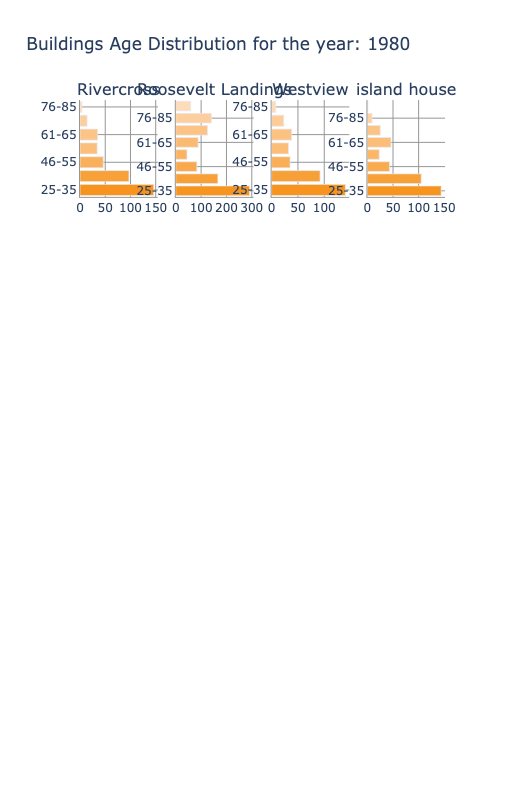

In [61]:
ridt_widgets.widget4()
age_fig_c_year,ds_cal = ridt_widgets.widget_4_action(df_ts_1)
age_fig_c_year.show()


## Now adding building events
# First Event Rivercross Between Start date 2003-01-01 and End date 2013-12-31 as
# Flaged 🚩
<img src='rc.jpg' width='250'/>


# 🚩Adding Building Event Time Series

In [78]:
#bld_ts = ridt_buildings_ts_obj(p_ds.json_bldgs, bldg_events)
#bld_ts.ds
df_ts_2 = ridt_WIRE.update_Wire_To_Market_rate(p_ds,bldg_events,df_ts_1) # Update WIRE to Market Rate

i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
Updating To Market Rate: Rivercross
Updating To Market Rate: island house
Updating To Market Rate: Westview
Updating To Market Rate: Roosevelt Landings


In [79]:
#df_ts_2.ds.to_excel('big_data_ri_nov_5.xlsx')

# Adding Market Simulation for Non WIRE buildings

In [80]:
rental_south_town = p_ds.ApartmentType_according_to_dict()
#rental_south_town

In [81]:
rental_south_town = rental_south_town.query("(Category=='Rental')&(Group=='SouthTown')")

In [82]:
rental_south_town

,bldgs_id,cnstrct_yr,Bldg Proje,Category,Group
7,480,2015,Riverwalk Point,Rental,SouthTown
11,405,2007,Riverwalk Crossing,Rental,SouthTown
13,465,2004,Riverwalk place,Rental,SouthTown
14,475,2004,Riverwalk place,Rental,SouthTown
15,460,2020,Riverwalk Point,Rental,SouthTown


In [83]:
# Todos
# Update Rent Price Range According to ctegory and real price range
# update Agents
# Take a subset of the Agents from these 5 buildins
# every year 
#their slary
# evey year increase rent
# if Burden above 38% get out

In [84]:
main_ds, work_ds = df_ts_2.detach_by_list_of_bld_keys(rental_south_town['bldgs_id'].values)

In [93]:
#work_ds.ds['built_year'].min().year

2004

In [94]:
years_range = range(work_ds.ds['built_year'].min().year,2060)

In [132]:
def check_rental_burden_for_year(year_,ppf_,ds):
    """This function recieves year, price per fe and returns the rent burden"""
    w_subset =ds.filter_ds_by_year(year_)
    w_subset.ds['current_year'] =year_
    w_subset.ds['annual_rent'] = ppf_ * 12 * w_subset.ds['Ap_sq_feet_size']
    w_subset.ds['annual_rent_burden'] = (w_subset.ds['annual_rent'] / w_subset.ds['income']).apply(lambda x: round(x,4))
    w_subset.ds.sort_values('annual_rent_burden',inplace=True)
    return (w_subset)


In [ ]:
    #def filter_by_condition(self,con):
    #    ds = self.ds.copy()
    #    sample_ds = ridt_agents_obj(ds[con])

In [135]:
y_ds =ridt_agents_obj(y_ds.ds)

In [ ]:
y_ds.filter_by_condition

In [138]:
def mark_rent_burden(ds,threshold=0.3):
    ds.ds.loc[ds.ds['annual_rent_burden']>=threshold,'comment 1'] = 'Rental Burden'
    return(ds)

In [140]:
y_=2004
ppf_ = ridt_info.rent_per_feet_market(y_)
y_ds = check_rental_burden_for_year(y_,ppf_,work_ds)
y_ds = mark_rent_burden(y_ds)

In [142]:
y_ds.ds

,ap_index,bld_key,address_door,Building Name,built_year,affordable_living,elderly_lving,Rental_Units,ApartmentType,annual_utilities,Ap_sq_feet_size,Ap_number_of_rooms,protected,Low_income,Upper_income,agent_action,move_in,birth_date,death_date,death_age,entrance_age,move_out,cause,income,annual_return_mortgage,annual_hoa_expenses,annual_expenses,annual_burden,agentID,previous_agentID,tenant_cycle,comment 1,comment 2,annual_mortgage_burden,annual_expenses_burden,current_year,annual_rent,annual_rent_burden
3416,230,475,475_230,Riverwalk place,2004-01-01,0,0,1,Rental,3000,1364.0,2.0,False,130442,260884,In Building,2004-01-01,1976-08-17,2085-01-01,109,28,2085-01-01,death,260688,0.0,0.0,0.0,0.0,e98984f5-8041-4796-bfe4-ccf5d00aeec9,0,0.0,,,NaN,NaN,2004,39119.52,0.1501
3180,130,465,465_130,Riverwalk place,2004-01-01,0,0,1,Rental,3000,1364.0,2.0,False,130442,260884,In Building,2004-01-01,1943-05-14,2009-01-01,66,61,2009-01-01,death,260087,0.0,0.0,0.0,0.0,c26c356b-17fb-4470-a997-656d1c2f33b3,0,0.0,,,NaN,NaN,2004,39119.52,0.1504
3392,206,475,475_206,Riverwalk place,2004-01-01,0,0,1,Rental,3000,1364.0,2.0,False,130442,260884,In Building,2004-01-01,1970-07-03,2048-01-01,78,34,2048-01-01,death,260135,0.0,0.0,0.0,0.0,d5712a88-2a15-4e70-bd91-c440eabe7905,0,0.0,,,NaN,NaN,2004,39119.52,0.1504
3365,179,475,475_179,Riverwalk place,2004-01-01,0,0,1,Rental,3000,1364.0,2.0,False,130442,260884,In Building,2004-01-01,1942-11-07,2027-01-01,85,62,2027-01-01,death,259434,0.0,0.0,0.0,0.0,9ee51605-0814-40dc-bbdd-33abeb649923,0,0.0,,,NaN,NaN,2004,39119.52,0.1508
3252,66,475,475_66,Riverwalk place,2004-01-01,1,0,1,Rental,3000,1364.0,2.0,False,130442,260884,In Building,2004-01-01,1965-12-12,2071-01-01,106,39,2071-01-01,death,259202,0.0,0.0,0.0,0.0,31d9be40-aa6b-48e3-bc45-3d9c9d9bbfbd,0,0.0,,,NaN,NaN,2004,39119.52,0.1509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,2,465,465_2,Riverwalk place,2004-01-01,1,0,1,Rental,3000,1364.0,2.0,False,34671,55473,In Building,2004-01-01,1956-12-07,2040-01-01,84,48,2040-01-01,death,38295,0.0,0.0,0.0,0.0,256ce976-4865-4c6c-83ac-0d1af097d9f5,0,0.0,Rental Burden,,NaN,NaN,2004,39119.52,1.0215
3050,0,465,465_0,Riverwalk place,2004-01-01,1,0,1,Rental,3000,1364.0,2.0,False,34671,55473,In Building,2004-01-01,1940-08-20,2015-01-01,75,64,2015-01-01,death,37917,0.0,0.0,0.0,0.0,1cdd0369-5f20-402c-bccb-358c4a856146,0,0.0,Rental Burden,,NaN,NaN,2004,39119.52,1.0317
3200,14,475,475_14,Riverwalk place,2004-01-01,1,0,1,Rental,3000,1364.0,2.0,False,34671,55473,In Building,2004-01-01,1946-10-20,2038-01-01,92,58,2038-01-01,death,37067,0.0,0.0,0.0,0.0,bf8561f5-5535-4df6-a8c0-49c0393a5f93,0,0.0,Rental Burden,,NaN,NaN,2004,39119.52,1.0554
3197,11,475,475_11,Riverwalk place,2004-01-01,1,0,1,Rental,3000,1364.0,2.0,False,34671,55473,In Building,2004-01-01,1954-12-12,2051-01-01,97,50,2051-01-01,death,36729,0.0,0.0,0.0,0.0,8ba18847-a5c8-4a3d-8c90-c7806be061de,0,0.0,Rental Burden,,NaN,NaN,2004,39119.52,1.0651


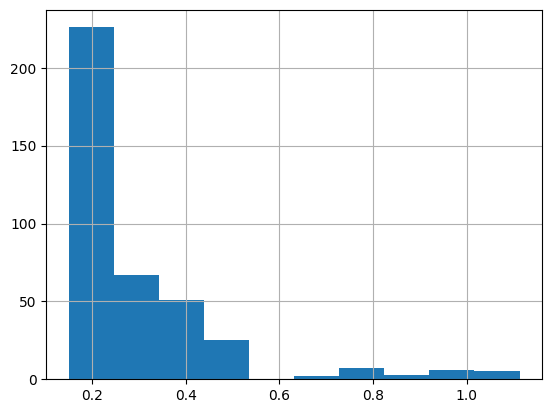

In [128]:
y_ds.ds['annual_rent_burden'].hist()

In [129]:
y_ds.ds['annual_rent_burden'].describe()

count    392.000000
mean       0.292761
std        0.181383
min        0.150100
25%        0.182900
50%        0.228750
75%        0.382600
max        1.113300
Name: annual_rent_burden, dtype: float64

In [125]:
y_ds.ds.head()

,ap_index,bld_key,address_door,Building Name,built_year,affordable_living,elderly_lving,Rental_Units,ApartmentType,annual_utilities,Ap_sq_feet_size,Ap_number_of_rooms,protected,Low_income,Upper_income,agent_action,move_in,birth_date,death_date,death_age,entrance_age,move_out,cause,income,annual_return_mortgage,annual_hoa_expenses,annual_expenses,annual_burden,agentID,previous_agentID,tenant_cycle,comment 1,comment 2,annual_mortgage_burden,annual_expenses_burden,current_year,Annual_Rent,Annual_Rent_Burden
3416,230,475,475_230,Riverwalk place,2004-01-01,0,0,1,Rental,3000,1364.0,2.0,False,130442,260884,In Building,2004-01-01,1976-08-17,2085-01-01,109,28,2085-01-01,death,260688,0.0,0.0,0.0,0.0,e98984f5-8041-4796-bfe4-ccf5d00aeec9,0,0.0,,,NaN,NaN,2004,39119.52,0.1501
3180,130,465,465_130,Riverwalk place,2004-01-01,0,0,1,Rental,3000,1364.0,2.0,False,130442,260884,In Building,2004-01-01,1943-05-14,2009-01-01,66,61,2009-01-01,death,260087,0.0,0.0,0.0,0.0,c26c356b-17fb-4470-a997-656d1c2f33b3,0,0.0,,,NaN,NaN,2004,39119.52,0.1504
3392,206,475,475_206,Riverwalk place,2004-01-01,0,0,1,Rental,3000,1364.0,2.0,False,130442,260884,In Building,2004-01-01,1970-07-03,2048-01-01,78,34,2048-01-01,death,260135,0.0,0.0,0.0,0.0,d5712a88-2a15-4e70-bd91-c440eabe7905,0,0.0,,,NaN,NaN,2004,39119.52,0.1504
3365,179,475,475_179,Riverwalk place,2004-01-01,0,0,1,Rental,3000,1364.0,2.0,False,130442,260884,In Building,2004-01-01,1942-11-07,2027-01-01,85,62,2027-01-01,death,259434,0.0,0.0,0.0,0.0,9ee51605-0814-40dc-bbdd-33abeb649923,0,0.0,,,NaN,NaN,2004,39119.52,0.1508
3252,66,475,475_66,Riverwalk place,2004-01-01,1,0,1,Rental,3000,1364.0,2.0,False,130442,260884,In Building,2004-01-01,1965-12-12,2071-01-01,106,39,2071-01-01,death,259202,0.0,0.0,0.0,0.0,31d9be40-aa6b-48e3-bc45-3d9c9d9bbfbd,0,0.0,,,NaN,NaN,2004,39119.52,0.1509


In [130]:
for y_ in years_range:
    ppf_ = ridt_info.rent_per_feet_market(y_)
    y_ds = check_rental_status_for_year(y_,ppf_,work_ds)

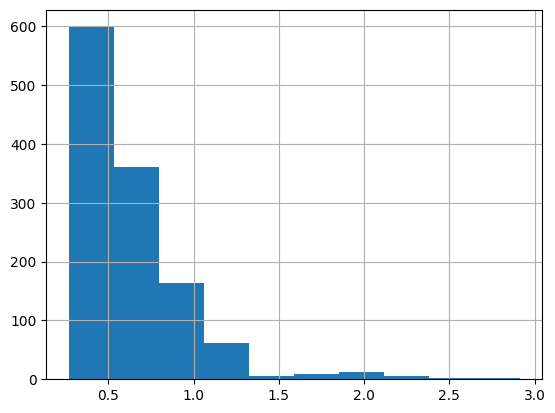

In [131]:
y_ds.ds['annual_rent_burden'].hist()

In [87]:
#df_ts_2.filter_by_list_of_bld_keys(rental_south_town['bldgs_id'].values).ds

In [88]:
main_ds.ds

,ap_index,bld_key,address_door,Building Name,built_year,affordable_living,elderly_lving,Rental_Units,ApartmentType,annual_utilities,Ap_sq_feet_size,Ap_number_of_rooms,protected,Low_income,Upper_income,agent_action,move_in,birth_date,death_date,death_age,entrance_age,move_out,cause,income,annual_return_mortgage,annual_hoa_expenses,annual_expenses,annual_burden,agentID,previous_agentID,tenant_cycle,comment 1,comment 2,annual_mortgage_burden,annual_expenses_burden
0,0,10-40,10-40_0,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560,107200,In Building,1989-01-01,1957-08-07,2045-01-01,88,32,2045-01-01,death,99396,0.0,0.000,0.000,0.000000,94b1b264-360e-442f-8345-78a2204bd6b8,0,0.0,,,NaN,NaN
1,1,10-40,10-40_1,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560,107200,In Building,1989-01-01,1959-11-23,2052-01-01,93,30,2052-01-01,death,56159,0.0,0.000,0.000,0.000000,5e66ba77-606a-4195-8efe-566b9197de03,0,0.0,,,NaN,NaN
2,2,10-40,10-40_2,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560,107200,In Building,1989-01-01,1941-07-03,2013-01-01,72,48,2013-01-01,death,65418,0.0,0.000,0.000,0.000000,fe06d2eb-5c04-4284-b787-634be2133fa5,0,0.0,,,NaN,NaN
3,3,10-40,10-40_3,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560,107200,In Building,1989-01-01,1933-04-18,1995-01-01,62,56,1995-01-01,death,68118,0.0,0.000,0.000,0.000000,aa54bb80-a7e0-491d-bbfc-d643ad65b3dc,0,0.0,,,NaN,NaN
4,4,10-40,10-40_4,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560,107200,In Building,1989-01-01,1931-06-28,2005-01-01,74,58,2005-01-01,death,75538,0.0,0.000,0.000,0.000000,6c6f26bd-db52-447b-8dd6-5545d1d96be8,0,0.0,,,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30412,992,500_580,500_580_992,Roosevelt Landings,1976-01-01,0,0,0,Other,0,2170.0,4.0,False,37399,39454,In Building,2059-01-01,2027-05-02,2140-01-01,113,32,2140-01-01,death,39300,8131.0,6495.678,14626.678,0.372180,4e3c71fc-b8f9-406e-b3c4-e4c3a5b2b510,1229fd56-7519-4d40-b8d5-afef19f020a7,2.0,Market Buy,,0.165284,0.165284
30413,995,500_580,500_580_995,Roosevelt Landings,1976-01-01,0,0,0,Other,0,2170.0,4.0,False,37399,39454,In Building,2059-01-01,2027-09-28,2125-01-01,98,32,2125-01-01,death,39314,8131.0,6495.678,14626.678,0.372048,3adb748e-0752-4ec7-986f-359944add4c2,640d7828-4aaf-4645-92de-76ddf7376451,2.0,Market Buy,,0.165226,0.165226
30414,997,500_580,500_580_997,Roosevelt Landings,1976-01-01,0,0,0,Other,0,2170.0,4.0,False,37399,39454,In Building,2059-01-01,2022-01-18,2146-01-01,124,37,2146-01-01,death,39188,8131.0,6495.678,14626.678,0.373244,bb3d064a-245d-4ff0-9d12-3d796ab5123a,1335fb35-b1a0-4cbe-b64f-be8297197a21,2.0,Market Buy,,0.165757,0.165757
30415,998,500_580,500_580_998,Roosevelt Landings,1976-01-01,0,0,0,Other,0,2170.0,4.0,False,37399,39454,In Building,2059-01-01,2022-08-26,2141-01-01,119,37,2141-01-01,death,38277,8131.0,6495.678,14626.678,0.382127,00693c37-b28b-4814-907a-fb54928cbb52,3c52d21a-d119-41e6-a89a-8bb45fc83dba,2.0,Market Buy,,0.169702,0.169702


In [99]:
df_ts_2.ds.head()

,ap_index,bld_key,address_door,Building Name,built_year,affordable_living,elderly_lving,Rental_Units,ApartmentType,annual_utilities,Ap_sq_feet_size,Ap_number_of_rooms,protected,Low_income,Upper_income,agent_action,move_in,birth_date,death_date,death_age,entrance_age,move_out,cause,income,annual_return_mortgage,annual_hoa_expenses,annual_expenses,annual_burden,agentID,previous_agentID,tenant_cycle,comment 1,comment 2,annual_mortgage_burden,annual_expenses_burden
0,0,10-40,10-40_0,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560,107200,In Building,1989-01-01,1956-04-05,2031-01-01,75,33,2031-01-01,death,75555,0.0,0.0,0.0,0.0,d10b60b2-fb4c-4c84-a100-41c05e00a439,0,0.0,,,NaN,NaN
1,1,10-40,10-40_1,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560,107200,In Building,1989-01-01,1940-04-02,2023-01-01,83,49,2023-01-01,death,60062,0.0,0.0,0.0,0.0,af0afc62-7a54-46bb-a932-37de233705f2,0,0.0,,,NaN,NaN
2,2,10-40,10-40_2,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560,107200,In Building,1989-01-01,1936-12-12,2013-01-01,77,53,2013-01-01,death,72043,0.0,0.0,0.0,0.0,70fef37b-728c-40d9-8e89-aab815d79ac1,0,0.0,,,NaN,NaN
3,3,10-40,10-40_3,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560,107200,In Building,1989-01-01,1949-11-18,2036-01-01,87,40,2036-01-01,death,79240,0.0,0.0,0.0,0.0,256b6148-39d1-4b91-8de5-00f454c6a198,0,0.0,,,NaN,NaN
4,4,10-40,10-40_4,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560,107200,In Building,1989-01-01,1931-04-12,1997-01-01,66,58,1997-01-01,death,48673,0.0,0.0,0.0,0.0,d3796e6c-c2f1-4e88-b4b0-3cae1baf2904,0,0.0,,,NaN,NaN


In [81]:
type(df_ts_2)

__main__.ridt_agents_ts_obj

In [36]:
#df_ts_2.ds.to_excel('population_time_series_nov_9.xlsx')
bld_ts = ridt_buildings_ts_obj(p_ds.json_bldgs, bldg_events)

i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7


In [37]:
c_df = df_ts_2.filter_ds_by_year(2020,True)

In [ ]:
#c_df.ds['ApartmentType'].unique()
c_df.ds[c_df.ds['bld_key']=='425']

,ap_index,bld_key,address_door,Building Name,built_year,affordable_living,elderly_lving,Rental_Units,ApartmentType,annual_utilities,Ap_sq_feet_size,Ap_number_of_rooms,protected,Low_income,Upper_income,agent_action,move_in,birth_date,death_date,death_age,entrance_age,move_out,cause,income,annual_return_mortgage,annual_hoa_expenses,annual_expenses,annual_burden,agentID,previous_agentID,tenant_cycle,comment 1,comment 2,annual_mortgage_burden,annual_expenses_burden
1737,0,425,425_0,Riverwalk Landing,2007-01-01,0,0,0,Other,0,1364.0,2.0,False,62067,146040,In Building,2007-01-01,1947-01-01,2039-01-01,92,60,2039-01-01,death,86181,0.0,0.0,0.0,0.0,53980f1e-655c-4351-812c-670946b87ab7,0,0.0,,,0.0,0.0
1738,1,425,425_1,Riverwalk Landing,2007-01-01,0,0,0,Other,0,1364.0,2.0,False,62067,146040,In Building,2007-01-01,1945-01-02,2025-01-01,80,62,2025-01-01,death,122871,0.0,0.0,0.0,0.0,33051e02-395b-4e9c-b087-967015fef896,0,0.0,,,0.0,0.0
1739,2,425,425_2,Riverwalk Landing,2007-01-01,0,0,0,Other,0,1364.0,2.0,False,62067,146040,In Building,2007-01-01,1951-07-24,2022-01-01,71,56,2022-01-01,death,133417,0.0,0.0,0.0,0.0,aeeba88a-1ac4-4d7d-9f6a-685b4a7dab2b,0,0.0,,,0.0,0.0
1741,4,425,425_4,Riverwalk Landing,2007-01-01,0,0,0,Other,0,1364.0,2.0,False,62067,146040,In Building,2007-01-01,1975-01-12,2060-01-01,85,32,2060-01-01,death,137776,0.0,0.0,0.0,0.0,5bd91200-7389-4a43-a77f-72dbb14892c7,0,0.0,,,0.0,0.0
1742,5,425,425_5,Riverwalk Landing,2007-01-01,0,0,0,Other,0,1364.0,2.0,False,62067,146040,In Building,2007-01-01,1949-04-26,2028-01-01,79,58,2028-01-01,death,117914,0.0,0.0,0.0,0.0,efc5b099-9e31-4a27-9b96-52e73749219d,0,0.0,,,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5685,182,425,425_182,Riverwalk Landing,2007-01-01,0,0,0,Other,0,1364.0,2.0,False,76074,178998,In Building,2019-01-02,1991-07-18,2092-01-01,101,28,2092-01-01,death,177965,0.0,0.0,0.0,0.0,9c9f3fb9-4cd6-4545-902f-2f8da74e1e02,96bd7564-a516-4bae-a729-8f44f339d9cc,1.0,,,0.0,0.0
5689,186,425,425_186,Riverwalk Landing,2007-01-01,0,0,0,Other,0,1364.0,2.0,False,73572,173112,In Building,2017-01-02,1987-04-25,2093-01-01,106,30,2093-01-01,death,73718,0.0,0.0,0.0,0.0,5fa20f52-5e40-4767-9d48-dc5be45d5b46,1ebc2581-4a3d-4301-9b31-0ce4f96c18dc,1.0,,,0.0,0.0
5706,203,425,425_203,Riverwalk Landing,2007-01-01,0,0,0,Other,0,1364.0,2.0,False,73572,173112,In Building,2017-01-02,1988-12-12,2100-01-01,112,29,2100-01-01,death,101997,0.0,0.0,0.0,0.0,5005dd59-ca2a-463e-97bb-87c425c0f37e,a0fbe3ce-00c9-473f-9027-f9ec6b8fe9df,1.0,,,0.0,0.0
5722,219,425,425_219,Riverwalk Landing,2007-01-01,0,0,0,Other,0,1364.0,2.0,False,63142,148571,In Building,2008-01-02,1977-01-14,2063-01-01,86,31,2063-01-01,death,93084,0.0,0.0,0.0,0.0,075c7d84-b91b-4997-87f3-b3c25f2bfcd2,69fb808e-f147-445e-b3d7-d448a1cd92a8,1.0,,,0.0,0.0


In [ ]:
p_ds.ds.groupby('bld_key').agg({'Building Name':'first','ap_index':'count','Rental_Units':'sum'}).reset_index().to_excel('buildings_group_by_bld_key.xlsx')

In [ ]:
p_ds.ds.head()

,ap_index,bld_key,address_door,Building Name,built_year,affordable_living,elderly_lving,Rental_Units,ApartmentType,annual_utilities,Ap_sq_feet_size,Ap_number_of_rooms,protected,Low_income,Upper_income
0,0,10-40,10-40_0,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560.371875,107200.875
1,1,10-40,10-40_1,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560.371875,107200.875
2,2,10-40,10-40_2,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560.371875,107200.875
3,3,10-40,10-40_3,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560.371875,107200.875
4,4,10-40,10-40_4,Manhattan park,1989-01-01,0,0,1,Rental,3000,1364.0,2.0,False,45560.371875,107200.875


# Get to know the Agents

In [ ]:
ridt_widgets.widget3()

Select year to show Agent Statistics:


IntSlider(value=1980, continuous_update=False, description='Year', max=2050, min=1975)

What Kind of Map?:


Dropdown(description='Number:', options=(('Basic', 1), ('Burden Map', 2), ('Three', 3)), value=1)

select Building:


Dropdown(description='Bldgs:', index=5, options=('Manhattan park', 'The Octagon', 'island house', 'The House',…

In [ ]:
year_1, map_type,bld = ridt_widgets.get_data_widget3()

In [ ]:
df2 = ridt_agents_obj(df_ts_2.ds.copy())

In [ ]:
df2_year = df2.filter_ds_by_year(year_1)
df2_rivercross_year = df2.filter_ds_by_year_building(year_1,bld)

In [ ]:
df2_rivercross_year.report_burden()

,annual_burden,Number Of Housholds
0,Less than 10.0 percent,534


In [ ]:
df2_year.ds

In [ ]:
df2_rivercross_year.ds.to_excel('rivercross2024.xlsx')

In [ ]:
df2_rivercross_year.report()

In [ ]:
df2_rivercross_year.ds.to_excel('rivercross_2020.xlsx')

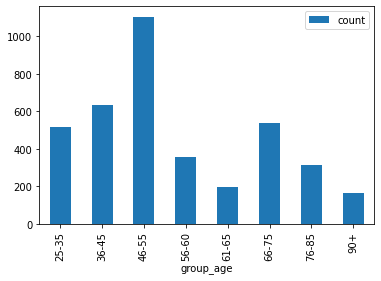

In [ ]:

df2_f1 = df2.filter_ds_by_year(year_1)
ca1 = ridt_demographic.group_ds_by_age(df2_f1.ds,year_1)
ca1.plot.bar(x='group_age')

In [ ]:
a_income_year = ridt_agent_economy.group_ds_income_group(df2_f1.ds)

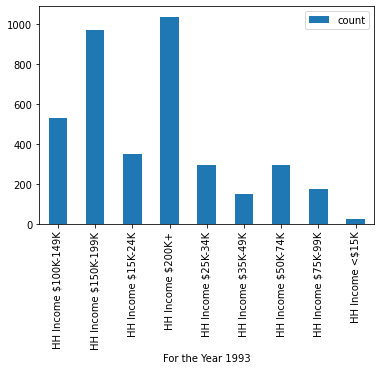

In [ ]:
a_income_year.plot.bar(x='income_category',xlabel='For the Year ' +str(year_1))

#Map Plotting

## Option 2 Burden Mapping

In [ ]:
#Preparing the data
# Group By Building and Burden Done
# Merge with Geodatabase Done
# Prepare Labeling

In [ ]:
m,json_burden = ridt_plotmaps.prepare_and_plot_burden(df2_year,json_bldgs)

In [ ]:
m

In [ ]:
json_burden

In [ ]:
json_burden.columns

In [ ]:
burden_map_by_year = ridt_agents_obj(df2_year.ds.copy())
burden_map_by_year.ds['annual_burden'] = burden_map_by_year.ds['annual_burden'].apply(ridt_agent_economy.get_burden_title)
burden_bap_by_year_bldg = burden_map_by_year.report_burden_by_building()

In [ ]:
jb1 = json_bldgs.copy()
col = ['Bldg Proje', 'cnstrct_yr','bld_key','Address', 'geometry']
jb1= jb1[col]

In [ ]:

jbbf2 = pd.merge(jb1, bbybp, how='right', right_on='Building Name', left_on='Bldg Proje')


In [ ]:
jbbf2.plot()

In [ ]:
json_bldgs.columns

In [ ]:
df2_rep = df2_f1.report()
df2_rep.columns = [' '.join(col).strip() for col in df2_rep.columns.values]
jbbf1 = pd.merge(jb1, df2_rep, how='right', right_on='Building Name', left_on='Bldg Proje')


In [ ]:
#part1 = ([' '.join(col).strip() for col in jbbf1.columns.values[0:-5]])
#part2 = part1 + list(df2_merge.columns.values[-5:])
#jbbf1.columns = part2
jbbf1['Affordable_ratio'] = jbbf1['Affordable Living sum']/jbbf1['Apartments count']


In [ ]:
jbbf1.plot()

# Test

In [ ]:
m = ridt_plotmaps.map_2(jbbf1)
#https://github.com/python-visualization/folium/tree/master/examples

In [ ]:
m

In [ ]:
fig2 = ridt_plot.plot_treemap_1(df2.ds.loc[df2.ds['Building Name']=='Rivercross'])
#fig2.write_html('treemap_example.html')
fig2.show()

In [ ]:
fig = ridt_plot.plot_treemap_2(df2.ds)
fig.show()

# New Section